# Code for making predictions with and without news features

## Libraries/Data required

In [36]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics

# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from helper_functions import *

data_dir = "given_data/" # Define data path

In [37]:
df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
print(len(df['district'].unique()))
df.set_index(["date", "district"], inplace=True) # Set index

# We're missing IPC values; I fill in previous IPC values based on time.
ipc_orig = df['ipc'] # Create copy of ipc column
df.insert(5, column='ipc_orig', value=ipc_orig) # Insert copy of ipc column
# fill in missing ipc values with ffill for each district
df['ipc'] = df.groupby(level=1)['ipc'].ffill()
# TODO: make visualisation of how many IPC values are missing.

78


## Basic visualizations

<br>
A bar chart showing the frequency of the different "fews_ipc" phases.

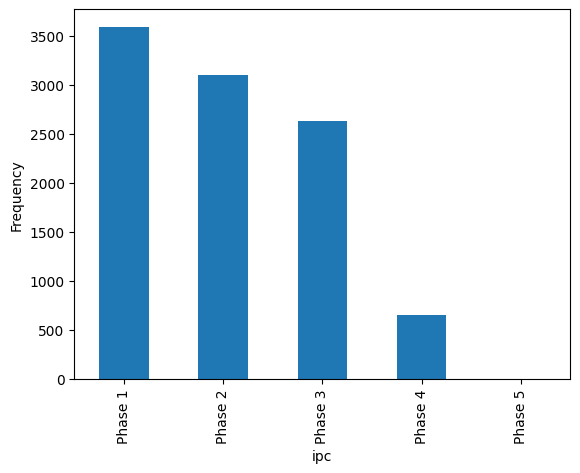

In [38]:
ax = df["ipc"].value_counts().plot(kind="bar") # Initialize barplot of fews_ipc counts
ax.set_xticklabels(["Phase {}".format(i) for i in range(1, 6)]) # Label the phases
ax.set_ylabel('Frequency'); # Set y label

<br>
A map of South Sudan showing the mean IPC per county (with geopandas).

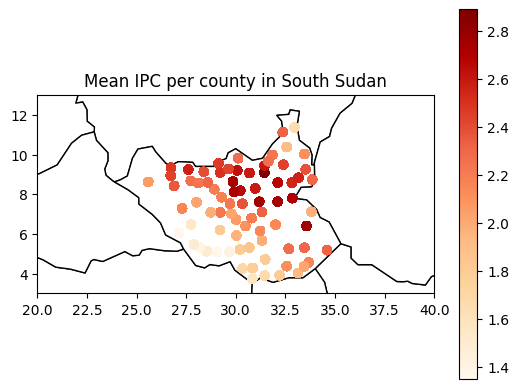

In [39]:
# Plot map of south sudan
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")) # Get map of the world

ax = world.plot(color="white", edgecolor="black") # Plot world map

# Bound map to south sudan
ax.set_xlim(20, 40)
ax.set_ylim(3, 13)

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["centx"], df["centy"])) # Initialize GeoDataFrame

# Calculate mean ipc per administration
mean_ipc = (
    df.reset_index()[["ipc", "district"]]
    .groupby("district")
    .mean()
    .rename(columns={"ipc": "mean_ipc"})
)

# Plot mean ipc per administration on map
gdf.merge(mean_ipc, on="district").plot(
    column="mean_ipc", ax=ax, legend=True, cmap="OrRd"
)

# Set plot title
ax.set_title("Mean IPC per county in South Sudan");

## Making Predictions

To simplify, we treat the IPC prediction problem as regression rather than classification,
e.g., multivariable logistic regression might be more suited.
<br><br>
We use a TimeSeriesSplit to divide the data into 5 training-test splits and run cross-validation on these splits. 
<br>We report the confusion matrix (with training and test split as title) along with the model summary per split; the mean MAE and mean R2 are reported after completion of cross-validation.
<br><br>
First however, we create multiple lagged variables in the cell directly below.

In [40]:
# Baseline with no news articles.
# Standard parameters that ZHL has created.
# Create several lagged columns to use as explanatory variables for the model
# All these columns are newly added.
df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

df.columns # View the newly created columns

Index(['country', 'district_code', 'centx', 'centy', 'year_month', 'ipc_orig',
       'year', 'month', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean',
       'rain_anom', 'et_mean', 'et_anom', 'count_violence', 'sum_fatalities',
       'food_price_idx', 'area', 'cropland_pct', 'pop', 'ruggedness_mean',
       'pasture_pct', 'count_violence_lag_3', 'ndvi_anom_lag_3',
       'food_price_idx_lag_3', 'ipc_lag_1', 'ipc_lag_2', 'ipc_lag_3'],
      dtype='object')

In [41]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column

                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     792.0
Date:                Thu, 26 Oct 2023   Prob (F-statistic):               0.00
Time:                        10:19:28   Log-Likelihood:                -236.04
No. Observations:                1430   AIC:                             486.1
Df Residuals:                    1423   BIC:                             522.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.6879 

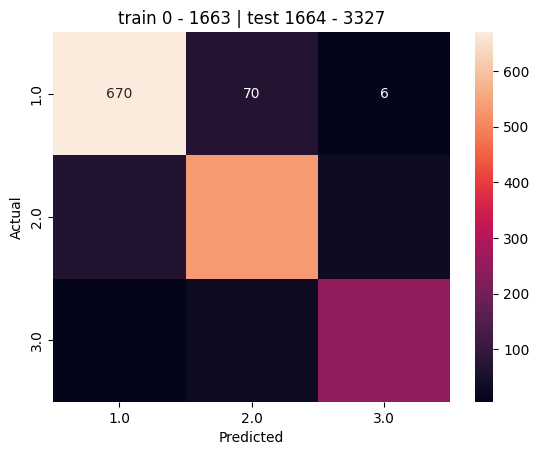

train accuraccy instant: 0.9223776223776223
test accuracy instant: 0.8737980769230769
                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     1584.
Date:                Thu, 26 Oct 2023   Prob (F-statistic):               0.00
Time:                        10:19:29   Log-Likelihood:                -1039.2
No. Observations:                3094   AIC:                             2092.
Df Residuals:                    3087   BIC:                             2135.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

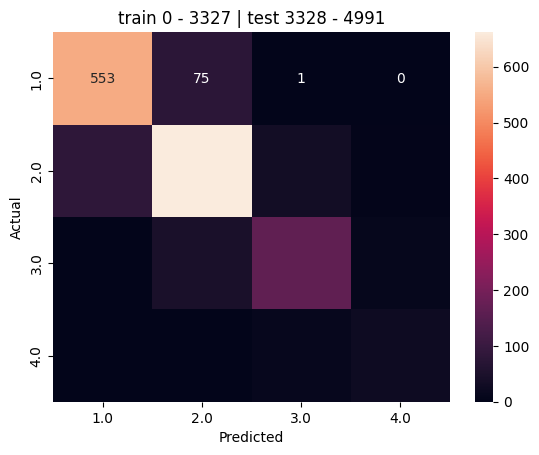

train accuraccy instant: 0.8962508080155139
test accuracy instant: 0.84375
                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     2363.
Date:                Thu, 26 Oct 2023   Prob (F-statistic):               0.00
Time:                        10:19:29   Log-Likelihood:                -1838.7
No. Observations:                4758   AIC:                             3691.
Df Residuals:                    4751   BIC:                             3737.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

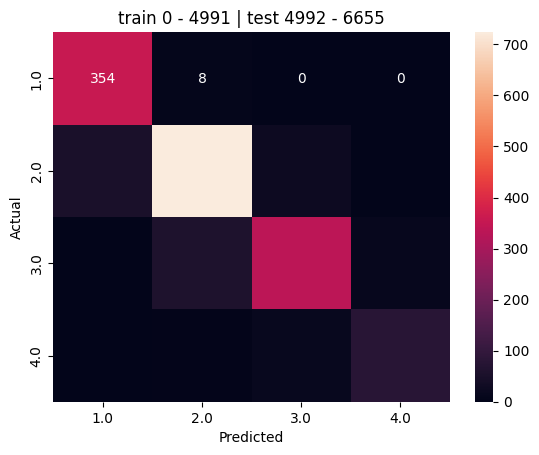

train accuraccy instant: 0.8778898696931484
test accuracy instant: 0.8966346153846154
                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     4135.
Date:                Thu, 26 Oct 2023   Prob (F-statistic):               0.00
Time:                        10:19:30   Log-Likelihood:                -2339.4
No. Observations:                6422   AIC:                             4693.
Df Residuals:                    6415   BIC:                             4740.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

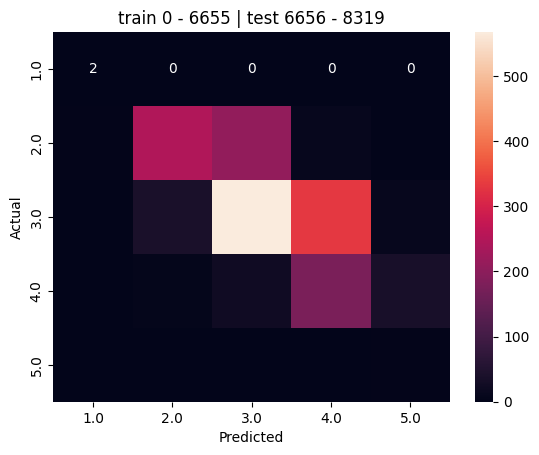

train accuraccy instant: 0.8827468078480224
test accuracy instant: 0.5979567307692307
                            OLS Regression Results                            
Dep. Variable:                    ipc   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     7078.
Date:                Thu, 26 Oct 2023   Prob (F-statistic):               0.00
Time:                        10:19:30   Log-Likelihood:                -2849.0
No. Observations:                8086   AIC:                             5712.
Df Residuals:                    8079   BIC:                             5761.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

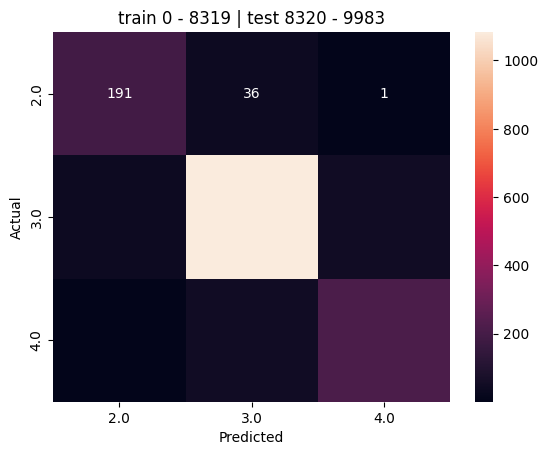

train accuraccy instant: 0.8867177838238931
test accuracy instant: 0.8954326923076923
Mean MAE: 0.25
Mean R2: 0.78
Mean train accuraccy: 0.89
Mean test accuraccy: 0.82


<Figure size 640x480 with 0 Axes>

In [42]:
X = df.iloc[:, -6:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

cv = TimeSeriesSplit(n_splits=5) # Define TimeSeriesSplit with 5 splits

# Initinalize empty lists to score scores
mae_values = list()
r2_values = list()
train_accuraccy = list()
test_accuraccy = list()

for train_index, val_index in cv.split(X): # Loop over the different training-test splits

    # Define X and y data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    #Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    model = OLS(y_train, X_train, missing="drop") # Initialize OLS model on training data
    results = model.fit() # Get model results on training data
    print(results.summary()) # Print model summary

    y_pred = results.predict(X_test) # Run model on test data
    
    # Append results to respective lists
    mae_values.append((y_pred - y_val['ipc']).abs().mean())
    r2_values.append(results.rsquared)
    
    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_val['ipc']); # Plot confusion matrix

    # Calculate accuraccy
    train_correct = ((results.predict(X_train).round()==y_train['ipc']).sum()) # ammount of correct train predictions
    test_correct = ((y_pred.round()==y_val['ipc']).sum()) # ammount of correct test predictions
    train_values_count = len(y_train['ipc'])-results.predict(X_train).round().isna().sum() # train values contain NaNs, so to calculate what values have been predicted we need to subtract the number of NaNs from the total number of values
    test_values_count = len(y_val['ipc'])-y_val['ipc'].isna().sum() # test values contain NaNs, so to calculate what values have been predicted we need to subtract the number of NaNs from the total number of values

    # Append accuraccy to respective lists
    train_accuraccy.append(train_correct/train_values_count)
    test_accuraccy.append(test_correct/test_values_count)
    print(f"train accuraccy instant: {train_correct/train_values_count}")
    print(f"test accuracy instant: {test_correct/test_values_count}")
    
print(f"Mean MAE: {np.mean(mae_values):.2f}") # Print MAE
print(f"Mean R2: {np.mean(r2_values):.2f}") # Print R2
print(f"Mean train accuraccy: {np.mean(train_accuraccy):.2f}") # Print train accuraccy
print(f"Mean test accuraccy: {np.mean(test_accuraccy):.2f}") # Print test accuraccy

## Incorporating News Features

We look at country wide news features to simplify. E.g., we do not look at topics per district

In [43]:
# Reads all the news articles
# Baseline with news articles
base_news_df = pd.read_csv(data_dir + "articles_topics.csv") # Read news data into DataFrame

# Create date column
base_news_df["date"] = pd.to_datetime(
    pd.to_datetime(base_news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",  # Articles don't have a day, everything is set to 1.
)
base_news_df.head()

,summary,date,location_article,lat,lng,hunger,refugees,humanitarian,conflict
0,The article discusses the passing of the new C...,2011-07-01,Juba,4.859363,31.571250,False,False,False,False
1,The article discusses the military actions tak...,2011-07-01,Abyei,9.838551,28.486396,False,False,False,False
2,The article discusses the signing of a Framewo...,2011-06-01,Southern Kordofan,11.036544,30.895824,False,False,False,False
3,The article discusses the upcoming independenc...,2011-07-01,South Sudan,6.876992,31.306979,False,False,False,False
4,The article discusses the need for South Sudan...,2011-07-01,Juba,4.859363,31.571250,False,False,False,False


### New data

LDA data

In [44]:
news_lda_df = pd.read_csv("created_data/final_output_lda.csv") # Read news data into DataFrame

# Create date column
news_lda_df["date"] = pd.to_datetime(
    pd.to_datetime(news_lda_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_lda_df.head()

,date,Unnamed: 0,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
0,2011-07-01,Doc0,0.34,0.00,0.55,0.0,0.00,0.00,0.07,0.00,0.00,0.03
1,2011-07-01,Doc1,0.16,0.00,0.47,0.0,0.00,0.28,0.00,0.08,0.00,0.00
2,2011-06-01,Doc2,0.00,0.00,0.24,0.0,0.57,0.00,0.00,0.18,0.00,0.00
3,2011-07-01,Doc3,0.56,0.00,0.12,0.0,0.00,0.00,0.04,0.12,0.14,0.00
4,2011-07-01,Doc4,0.00,0.11,0.00,0.0,0.00,0.88,0.00,0.00,0.00,0.00


In [45]:
pd.set_option('display.max_columns', None) # Display all columns in DataFrame

Rake paragraphs

In [46]:
news_rp_df = pd.read_csv("created_data/df_rake_paragraphs.csv") # Read news data into DataFrame

# Create date column
news_rp_df["date"] = pd.to_datetime(
    pd.to_datetime(news_rp_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_rp_df.head()

,Unnamed: 0.1,Unnamed: 0,index,name,summary,date,lat,lng,paragraphs,publisher,tags,summary_rake_keywords,paragraphs_rake_keywords,paragraphs_3_keywords_2gram_summary,keywords_paragraphs,['sudan'],['south'],['said'],['government'],['people'],['also'],['juba'],['country'],['president'],['state'],['sudanese'],['two'],['—'],"[',""']",['peace'],['one'],['security'],['kiir'],['last'],['since'],['would'],['international'],['new'],['conflict'],['salva'],['year'],['national'],['united'],['war'],['political'],['states'],['countries'],['time'],['including'],"['.""']",['minister'],['many'],['support'],['agreement'],['told'],['first'],['forces'],['well'],['however'],['nations'],['african'],['development'],['un'],['general'],['former'],['article'],['discusses'],['due'],['violence'],['000'],['humanitarian'],['machar'],['need'],['oil'],['ongoing'],['riek'],['unity'],['million'],['issues'],['fighting'],['highlights'],['talks'],['Sudan'],['South'],[''],['President'],['Juba'],['Kiir'],['Abyei'],['Machar'],['Sudanese'],['State'],['Bor'],['African'],['Uganda'],['Jonglei'],['Council'],['Darfur'],['Nile'],['United'],['Minister'],['Nuer'],['Khartoum'],['Government'],['Police'],['Ethiopia'],['Wau'],['Republic'],['Yau'],['Kenya'],['Health'],['Pibor'],['Bentiu'],['Rumbek'],['Ministry'],['University'],['Ababa'],['Malakal'],['Africa'],['Lakes'],['Unity'],['Bank'],['Murle'],['National'],['Commission'],['Human'],['Equatoria'],['Security'],['Mission'],['Food'],['Children'],['East'],['County'],['Riek'],['December'],['Salva'],['General'],['Union'],['Ghazal'],['Ugandan'],['Hon'],['Somalia'],['China'],['Conflict'],['Peace'],['Famine'],['Politics'],['Aid'],['UN'],['Violence'],['Refugee'],['Election'],['Corruption'],['Humanitarian'],['Economy'],['SecurityRebel'],['Independence'],['Poverty'],['Oil'],['Diplomacy'],['Healthcare'],['Education'],['Militia'],['Inflation'],['Crisis'],['Sanctions'],['Child'],['Displacement'],['Peacekeeping'],['Resolution'],['Democracy'],['War'],['Infrastructure'],['Woman'],['Media'],['Ethnicity'],['Mediation'],['Coup'],['Agriculture'],['Water'],['Development'],['Youth'],['Judicial'],['Energy'],['Childbirth'],['Conservation'],['Forest'],['Mining'],['Tribes'],['Injustice']
0,0,0,The article discusses the passing of the new C...,Juba,The article discusses the passing of the new C...,2011-07-01,4.859363,31.571250,Juba — THE parliament of South Sudan has passe...,New Vision (Kampala),"['South Sudan', 'East Africa', 'Governance', '...","['article', 'discusses', 'passing', 'new', 'co...","['juba', '—', 'parliament', 'south', 'sudan', ...","[('South Sudan', 0.005289617611018771), ('Suda...","[('South Sudan', 0.0012728742031249375), ('Sud...",False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,1,1,The article discusses the military actions tak...,Abyei,The article discusses the military actions tak...,2011-07-01,9.838551,28.486396,What is the logic of Khartoum's military actio...,South Sudan News Agency,"['South Sudan', 'East Africa', 'Business', 'Co...","['article', 'discusse

Rake summary

In [47]:
news_rs_df = pd.read_csv("created_data/df_rake_summary.csv") # Read news data into DataFrame

# Create date column
news_rs_df["date"] = pd.to_datetime(
    pd.to_datetime(news_rs_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_rs_df.head()

,Unnamed: 0.1,Unnamed: 0,index,name,summary,date,lat,lng,paragraphs,publisher,tags,summary_rake_keywords,paragraphs_rake_keywords,paragraphs_3_keywords_2gram_summary,keywords_paragraphs,['sudan'],['south'],['said'],['government'],['people'],['also'],['juba'],['country'],['president'],['state'],['sudanese'],['two'],['—'],"[',""']",['peace'],['one'],['security'],['kiir'],['last'],['since'],['would'],['international'],['new'],['conflict'],['salva'],['year'],['national'],['united'],['war'],['political'],['states'],['countries'],['time'],['including'],"['.""']",['minister'],['many'],['support'],['agreement'],['told'],['first'],['forces'],['well'],['however'],['nations'],['african'],['development'],['un'],['general'],['former'],['article'],['discusses'],['due'],['violence'],['000'],['humanitarian'],['machar'],['need'],['oil'],['ongoing'],['riek'],['unity'],['million'],['issues'],['fighting'],['highlights'],['talks'],['Sudan'],['South'],[''],['President'],['Juba'],['Kiir'],['Abyei'],['Machar'],['Sudanese'],['State'],['Bor'],['African'],['Uganda'],['Jonglei'],['Council'],['Darfur'],['Nile'],['United'],['Minister'],['Nuer'],['Khartoum'],['Government'],['Police'],['Ethiopia'],['Wau'],['Republic'],['Yau'],['Kenya'],['Health'],['Pibor'],['Bentiu'],['Rumbek'],['Ministry'],['University'],['Ababa'],['Malakal'],['Africa'],['Lakes'],['Unity'],['Bank'],['Murle'],['National'],['Commission'],['Human'],['Equatoria'],['Security'],['Mission'],['Food'],['Children'],['East'],['County'],['Riek'],['December'],['Salva'],['General'],['Union'],['Ghazal'],['Ugandan'],['Hon'],['Somalia'],['China'],['Conflict'],['Peace'],['Famine'],['Politics'],['Aid'],['UN'],['Violence'],['Refugee'],['Election'],['Corruption'],['Humanitarian'],['Economy'],['SecurityRebel'],['Independence'],['Poverty'],['Oil'],['Diplomacy'],['Healthcare'],['Education'],['Militia'],['Inflation'],['Crisis'],['Sanctions'],['Child'],['Displacement'],['Peacekeeping'],['Resolution'],['Democracy'],['War'],['Infrastructure'],['Woman'],['Media'],['Ethnicity'],['Mediation'],['Coup'],['Agriculture'],['Water'],['Development'],['Youth'],['Judicial'],['Energy'],['Childbirth'],['Conservation'],['Forest'],['Mining'],['Tribes'],['Injustice']
0,0,0,The article discusses the passing of the new C...,Juba,The article discusses the passing of the new C...,2011-07-01,4.859363,31.571250,Juba — THE parliament of South Sudan has passe...,New Vision (Kampala),"['South Sudan', 'East Africa', 'Governance', '...","['article', 'discusses', 'passing', 'new', 'co...","['juba', '—', 'parliament', 'south', 'sudan', ...","[('South Sudan', 0.005289617611018771), ('Suda...","[('South Sudan', 0.0012728742031249375), ('Sud...",False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,1,1,The article discusses the military actions tak...,Abyei,The article discusses the military actions tak...,2011-07-01,9.838551,28.486396,What is the logic of Khartoum's military actio...,South Sudan News Agency,"['South Sudan', 'East Africa', 'Business', 'Co...","['article', 'discusse

Yake paragraphs

In [48]:
news_yp_df = pd.read_csv("created_data/df_yake_paragraphs.csv") # Read news data into DataFrame

# Create date column
news_yp_df["date"] = pd.to_datetime(
    pd.to_datetime(news_yp_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_yp_df.head()

,Unnamed: 0.1,Unnamed: 0,index,name,summary,date,lat,lng,paragraphs,publisher,tags,summary_rake_keywords,paragraphs_rake_keywords,paragraphs_3_keywords_2gram_summary,keywords_paragraphs,['sudan'],['south'],['said'],['government'],['people'],['also'],['juba'],['country'],['president'],['state'],['sudanese'],['two'],['—'],"[',""']",['peace'],['one'],['security'],['kiir'],['last'],['since'],['would'],['international'],['new'],['conflict'],['salva'],['year'],['national'],['united'],['war'],['political'],['states'],['countries'],['time'],['including'],"['.""']",['minister'],['many'],['support'],['agreement'],['told'],['first'],['forces'],['well'],['however'],['nations'],['african'],['development'],['un'],['general'],['former'],['article'],['discusses'],['due'],['violence'],['000'],['humanitarian'],['machar'],['need'],['oil'],['ongoing'],['riek'],['unity'],['million'],['issues'],['fighting'],['highlights'],['talks'],['Sudan'],['South'],[''],['President'],['Juba'],['Kiir'],['Abyei'],['Machar'],['Sudanese'],['State'],['Bor'],['African'],['Uganda'],['Jonglei'],['Council'],['Darfur'],['Nile'],['United'],['Minister'],['Nuer'],['Khartoum'],['Government'],['Police'],['Ethiopia'],['Wau'],['Republic'],['Yau'],['Kenya'],['Health'],['Pibor'],['Bentiu'],['Rumbek'],['Ministry'],['University'],['Ababa'],['Malakal'],['Africa'],['Lakes'],['Unity'],['Bank'],['Murle'],['National'],['Commission'],['Human'],['Equatoria'],['Security'],['Mission'],['Food'],['Children'],['East'],['County'],['Riek'],['December'],['Salva'],['General'],['Union'],['Ghazal'],['Ugandan'],['Hon'],['Somalia'],['China'],['Conflict'],['Peace'],['Famine'],['Politics'],['Aid'],['UN'],['Violence'],['Refugee'],['Election'],['Corruption'],['Humanitarian'],['Economy'],['SecurityRebel'],['Independence'],['Poverty'],['Oil'],['Diplomacy'],['Healthcare'],['Education'],['Militia'],['Inflation'],['Crisis'],['Sanctions'],['Child'],['Displacement'],['Peacekeeping'],['Resolution'],['Democracy'],['War'],['Infrastructure'],['Woman'],['Media'],['Ethnicity'],['Mediation'],['Coup'],['Agriculture'],['Water'],['Development'],['Youth'],['Judicial'],['Energy'],['Childbirth'],['Conservation'],['Forest'],['Mining'],['Tribes'],['Injustice']
0,0,0,The article discusses the passing of the new C...,Juba,The article discusses the passing of the new C...,2011-07-01,4.859363,31.571250,Juba — THE parliament of South Sudan has passe...,New Vision (Kampala),"['South Sudan', 'East Africa', 'Governance', '...","['article', 'discusses', 'passing', 'new', 'co...","['juba', '—', 'parliament', 'south', 'sudan', ...","[('South Sudan', 0.005289617611018771), ('Suda...","[('South Sudan', 0.0012728742031249375), ('Sud...",False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,1,1,The article discusses the military actions tak...,Abyei,The article discusses the military actions tak...,2011-07-01,9.838551,28.486396,What is the logic of Khartoum's military actio...,South Sudan News Agency,"['South Sudan', 'East Africa', 'Business', 'Co...","['article', 'discusse

Yake summary

In [49]:
news_ys_df = pd.read_csv("created_data/df_yake_summary.csv") # Read news data into DataFrame

# Create date column
news_ys_df["date"] = pd.to_datetime(
    pd.to_datetime(news_ys_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_ys_df.head()

,Unnamed: 0.1,Unnamed: 0,index,name,summary,date,lat,lng,paragraphs,publisher,tags,summary_rake_keywords,paragraphs_rake_keywords,paragraphs_3_keywords_2gram_summary,keywords_paragraphs,['sudan'],['south'],['said'],['government'],['people'],['also'],['juba'],['country'],['president'],['state'],['sudanese'],['two'],['—'],"[',""']",['peace'],['one'],['security'],['kiir'],['last'],['since'],['would'],['international'],['new'],['conflict'],['salva'],['year'],['national'],['united'],['war'],['political'],['states'],['countries'],['time'],['including'],"['.""']",['minister'],['many'],['support'],['agreement'],['told'],['first'],['forces'],['well'],['however'],['nations'],['african'],['development'],['un'],['general'],['former'],['article'],['discusses'],['due'],['violence'],['000'],['humanitarian'],['machar'],['need'],['oil'],['ongoing'],['riek'],['unity'],['million'],['issues'],['fighting'],['highlights'],['talks'],['Sudan'],['South'],[''],['President'],['Juba'],['Kiir'],['Abyei'],['Machar'],['Sudanese'],['State'],['Bor'],['African'],['Uganda'],['Jonglei'],['Council'],['Darfur'],['Nile'],['United'],['Minister'],['Nuer'],['Khartoum'],['Government'],['Police'],['Ethiopia'],['Wau'],['Republic'],['Yau'],['Kenya'],['Health'],['Pibor'],['Bentiu'],['Rumbek'],['Ministry'],['University'],['Ababa'],['Malakal'],['Africa'],['Lakes'],['Unity'],['Bank'],['Murle'],['National'],['Commission'],['Human'],['Equatoria'],['Security'],['Mission'],['Food'],['Children'],['East'],['County'],['Riek'],['December'],['Salva'],['General'],['Union'],['Ghazal'],['Ugandan'],['Hon'],['Somalia'],['China'],['Conflict'],['Peace'],['Famine'],['Politics'],['Aid'],['UN'],['Violence'],['Refugee'],['Election'],['Corruption'],['Humanitarian'],['Economy'],['SecurityRebel'],['Independence'],['Poverty'],['Oil'],['Diplomacy'],['Healthcare'],['Education'],['Militia'],['Inflation'],['Crisis'],['Sanctions'],['Child'],['Displacement'],['Peacekeeping'],['Resolution'],['Democracy'],['War'],['Infrastructure'],['Woman'],['Media'],['Ethnicity'],['Mediation'],['Coup'],['Agriculture'],['Water'],['Development'],['Youth'],['Judicial'],['Energy'],['Childbirth'],['Conservation'],['Forest'],['Mining'],['Tribes'],['Injustice']
0,0,0,The article discusses the passing of the new C...,Juba,The article discusses the passing of the new C...,2011-07-01,4.859363,31.571250,Juba — THE parliament of South Sudan has passe...,New Vision (Kampala),"['South Sudan', 'East Africa', 'Governance', '...","['article', 'discusses', 'passing', 'new', 'co...","['juba', '—', 'parliament', 'south', 'sudan', ...","[('South Sudan', 0.005289617611018771), ('Suda...","[('South Sudan', 0.0012728742031249375), ('Sud...",False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,1,1,The article discusses the military actions tak...,Abyei,The article discusses the military actions tak...,2011-07-01,9.838551,28.486396,What is the logic of Khartoum's military actio...,South Sudan News Agency,"['South Sudan', 'East Africa', 'Business', 'Co...","['article', 'discusse

Chatgpt

In [50]:
news_gpt_df = pd.read_csv("created_data/df_chatgpt.csv") # Read news data into DataFrame

# Create date column
news_gpt_df["date"] = pd.to_datetime(
    pd.to_datetime(news_gpt_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
news_gpt_df.head()

,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,index,name,summary,date,lat,lng,paragraphs,publisher,tags,keywords_summary,keywords_paragraphs,paragraphs_3_keywords_2gram_summary,summary_rake_keywords,paragraphs_rake_keywords,['Conflict'],['Peace'],['Famine'],['Politics'],['Aid'],['UN'],['Government'],['Violence'],['Refugee'],['Election'],['Corruption'],['Humanitarian'],['Economy'],['Security'],['Rebel'],['Independence'],['Poverty'],['Oil'],['Diplomacy'],['Healthcare'],['Education'],['Militia'],['Inflation'],['Crisis'],['Food'],['Sanctions'],['Child'],['Displacement'],['Peacekeeping'],['Resolution'],['Democracy'],['War'],['Infrastructure'],['Woman'],['Media'],['Ethnicity'],['Mediation'],['Coup'],['Agriculture'],['Water'],['Development'],['Youth'],['Judicial'],['Energy'],['Childbirth'],['Conservation'],['Forest'],['Mining'],['Tribes'],['Injustice']
0,0,0,0,0,0,0,The article discusses the passing of the new C...,Juba,The article discusses the passing of the new C...,2011-07-01,4.859363,31.571250,Juba — THE parliament of South Sudan has passe...,New Vision (Kampala),"['South Sudan', 'East Africa', 'Governance', '...","[('Sudan', 0.030890419886833533)]","[('South Sudan', 0.0012728742031249375), ('Sud...","[('South Sudan', 0.005289617611018771), ('Suda...","['article', 'discusses', 'passing', 'new', 'co...","['juba', '—', 'parliament', 'south', 'sudan', ...",False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False
1,1,1,1,1,1,1,The article discusses the military actions tak...,Abyei,The article discusses the military actions tak...,2011-07-01,9.838551,28.486396,What is the logic of Khartoum's military actio...,South Sudan News Agency,"['South Sudan', 'East Africa', 'Business', 'Co...","[('Sudan', 0.02542656284803938)]","[('South Sudan', 0.0029531024723219814), ('Sou...","[('North Sudan', 0.011030950211187246), ('Sout...","['article', 'discusses', 'military', 'actions'...","['logic', 'khartoum', 'military', 'actions', '...",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2,2,2,2,2,2,The article discusses the signing of a Framewo...,Southern Kordofan,The article discusses the signing of a Framewo...,2011-06-01,11.036544,30.895824,Secretary-General Ban Ki-moon today welcomed t...,UN News Service,"['Sudan', 'East Africa', 'Governance', 'Extern...","[('Southern', 0.04452588645312403)]","[('Southern Kordofan', 0.00457523637245708), (...","[('Addis Ababa', 0.0039625503330446826), ('Ban...","['article', 'discusses', 'signing', 'framework...","['secretary', 'general', 'ban', 'ki', 'moon', ...",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,3,3,3,3,3,3,The article discusses the upcoming independenc...,South Sudan,The article discusses the upcoming independenc...,2011-07-01,6.876992,31.306979,AS South Sudan readies itself to become the wo...,The Moment (London),"['Sudan', 'East Africa', 'Africa', 'South Sudan']","[('Sudan', 0.03705216593247519)]","[('South Sudan', 0.0030066658092349776), ('Chr...","[('South Sudan', 0.005189302388800585), ('upco...","['article', 'discusses', 'upcoming', 'independ...","['south', 'sudan', 'readies', 'become', 'world...",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,F

### Visualization of news features over time

The 2017 South Sudan famine is very apparent. Most of this event needs to be predicted out-of-sample with the training/test split we chose.

More info on the famine : https://en.wikipedia.org/wiki/2017_South_Sudan_famine

In [51]:
news_rs_df

,Unnamed: 0.1,Unnamed: 0,index,name,summary,date,lat,lng,paragraphs,publisher,tags,summary_rake_keywords,paragraphs_rake_keywords,paragraphs_3_keywords_2gram_summary,keywords_paragraphs,['sudan'],['south'],['said'],['government'],['people'],['also'],['juba'],['country'],['president'],['state'],['sudanese'],['two'],['—'],"[',""']",['peace'],['one'],['security'],['kiir'],['last'],['since'],['would'],['international'],['new'],['conflict'],['salva'],['year'],['national'],['united'],['war'],['political'],['states'],['countries'],['time'],['including'],"['.""']",['minister'],['many'],['support'],['agreement'],['told'],['first'],['forces'],['well'],['however'],['nations'],['african'],['development'],['un'],['general'],['former'],['article'],['discusses'],['due'],['violence'],['000'],['humanitarian'],['machar'],['need'],['oil'],['ongoing'],['riek'],['unity'],['million'],['issues'],['fighting'],['highlights'],['talks'],['Sudan'],['South'],[''],['President'],['Juba'],['Kiir'],['Abyei'],['Machar'],['Sudanese'],['State'],['Bor'],['African'],['Uganda'],['Jonglei'],['Council'],['Darfur'],['Nile'],['United'],['Minister'],['Nuer'],['Khartoum'],['Government'],['Police'],['Ethiopia'],['Wau'],['Republic'],['Yau'],['Kenya'],['Health'],['Pibor'],['Bentiu'],['Rumbek'],['Ministry'],['University'],['Ababa'],['Malakal'],['Africa'],['Lakes'],['Unity'],['Bank'],['Murle'],['National'],['Commission'],['Human'],['Equatoria'],['Security'],['Mission'],['Food'],['Children'],['East'],['County'],['Riek'],['December'],['Salva'],['General'],['Union'],['Ghazal'],['Ugandan'],['Hon'],['Somalia'],['China'],['Conflict'],['Peace'],['Famine'],['Politics'],['Aid'],['UN'],['Violence'],['Refugee'],['Election'],['Corruption'],['Humanitarian'],['Economy'],['SecurityRebel'],['Independence'],['Poverty'],['Oil'],['Diplomacy'],['Healthcare'],['Education'],['Militia'],['Inflation'],['Crisis'],['Sanctions'],['Child'],['Displacement'],['Peacekeeping'],['Resolution'],['Democracy'],['War'],['Infrastructure'],['Woman'],['Media'],['Ethnicity'],['Mediation'],['Coup'],['Agriculture'],['Water'],['Development'],['Youth'],['Judicial'],['Energy'],['Childbirth'],['Conservation'],['Forest'],['Mining'],['Tribes'],['Injustice']
0,0,0,The article discusses the passing of the new C...,Juba,The article discusses the passing of the new C...,2011-07-01,4.859363,31.571250,Juba — THE parliament of South Sudan has passe...,New Vision (Kampala),"['South Sudan', 'East Africa', 'Governance', '...","['article', 'discusses', 'passing', 'new', 'co...","['juba', '—', 'parliament', 'south', 'sudan', ...","[('South Sudan', 0.005289617611018771), ('Suda...","[('South Sudan', 0.0012728742031249375), ('Sud...",False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,1,1,The article discusses the military actions tak...,Abyei,The article discusses the military actions tak...,2011-07-01,9.838551,28.486396,What is the logic of Khartoum's military actio...,South Sudan News Agency,"['South Sudan', 'East Africa', 'Business', 'Co...","['article', 'discusse

In [52]:
# # country wide news features
# Choose the columns that will be used for the predictions
news_features_base = create_news_features(base_news_df, [base_news_df.columns[-4:]])  # The last x are the keywords.
news_features_lda = create_news_features(news_lda_df, [news_lda_df.columns[-10:]])
news_features_rp = create_news_features(news_rp_df, [news_rp_df.columns[-49:]])
news_features_rs = create_news_features(news_rs_df, [news_rs_df.columns[-49:]])
news_features_yp = create_news_features(news_yp_df, [news_yp_df.columns[-49:]])
news_features_ys = create_news_features(news_ys_df, [news_ys_df.columns[-49:]])
news_features_gpt = create_news_features(news_gpt_df, [news_gpt_df.columns[-20:]])
news_features_base

,hunger,refugees,humanitarian,conflict
date,,,,
2011-06-01,NaN,NaN,NaN,NaN
2011-07-01,NaN,NaN,NaN,NaN
2011-08-01,NaN,NaN,NaN,NaN
2011-09-01,NaN,NaN,NaN,NaN
2011-10-01,NaN,NaN,NaN,NaN
...,...,...,...,...
2022-12-01,0.022222,0.027778,0.044444,0.000000
2023-01-01,0.022222,0.027778,0.044444,0.000000
2023-02-01,0.083333,0.027778,0.041667,0.000000


In [53]:
df

country  district_code     centx     centy  \
date       district                                                       
2009-07-01 Abiemnhom     South Sudan            136  29.13019  9.550939   
           Akobo         South Sudan            114  32.85308  7.799214   
           Anzara        South Sudan             86  28.20598  5.309739   
           Aweil Center  South Sudan            128  26.89562  8.417934   
           Aweil East    South Sudan            141  27.61364  9.243139   
...                              ...            ...       ...       ...   
2020-02-01 Wulu          South Sudan            105  29.20889  6.200243   
           Yambio        South Sudan             82  28.54729  5.124909   
           Yei           South Sudan             81  30.34454  4.252148   
           Yirol East    South Sudan            107  30.80245  6.793194   
           Yirol West    South Sudan            101  30.48698  6.395244   

                        year_month  ipc_orig  year  month  ipc   ha  \
date       district                                                   
2009-07-01 Abiemnhom       2009_07       2.0  2009      7  2.0  NaN   
           Akobo           2009_07       4.0  2009      7  4.0  NaN   
           Anzara          2009_07       1.0  2009      7  1.0  NaN   
           Aweil Center    2009_07       2.0  2009      7  2.0  NaN   
           Aweil East      2009_07       3.0  2009      7  3.0  NaN   
...                            ...       ...   ...    ...  ...  ...   
2020-02-01 Wulu            2020_02       2.0  2020      2  2.0  0.0   
           Yambio          2020_02       3.0  2020      2  3.0  0.0   
           Yei             2020_02       3.0  2020      2  3.0  0.0   
           Yirol East      2020_02       4.0  2020      2  4.0  0.0   
           Yirol West      2020_02       3.0  2020      2  3.0  0.0   

                         ndvi_mean  ndvi_anom  rain_mean  rain_anom  \
date       district                                                   
2009-07-01 Abiemnhom      0.698165   96.42507  21.596120  -6.204614   
           Akobo          0.474723   76.47572  18.402520 -12.032300   
           Anzara         0.812001  100.25750  22.977350  -5.924453   
           Aweil Center   0.723154   94.34696  28.023920  -5.272942   
           Aweil East     0.547611   86.30622  25.439220  -4.701670   
...                            ...        ...        ...        ...   
2020-02-01 Wulu           0.374735  108.55950   0.665396  -0.278134   
           Yambio         0.468085  103.87600   1.465522  -1.156105   
           Yei            0.452878  105.17720   2.409410  -0.666829   
           Yirol East     0.410408  118.85030   0.488650  -0.015074   
           Yirol West     0.319411  117.96820   0.574698  -0.129652   

                           et_mean   et_anom  count_violence  sum_fatalities  \
date       district                                                            
2009-07-01 Abiemnhom     19.424150 -6.927661               0               0   
           Akobo         12.348940 -9.442238               2             161   
           Anzara        35.795540 -0.783660               1               0   
           Aweil Center  27.461880 -1.903216               0               0   
           Aweil East    14.422160 -4.741739               0               0   
...                            ...       ...             ...             ...   
2020-02-01 Wulu           0.125452 -0.243994               1               1   
           Yambio         2.018053  0.066441               0               0   
           Yei            7.450696  4.531602               0               0   
           Yirol East     0.547773  0.065478               1               5   
           Yirol West     0.193867 -0.108897               2              14   

                         food_price_idx       area  cropland_pct        pop  \
date       district                                                           
2009-0

In [54]:
# # Test cell, same as in the function below.
# ndf = df.copy()
# ndf.sort_index(level=0, inplace=True) # Sort DataFrame by date
# ndf = ndf.iloc[ndf['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
# # Locations do not matter to us; every district has the same topic value.
# ndf = ndf.join(news_features_base, how="left") # Join df with created news features
# ndf.dropna(subset=ndf.iloc[:,-len(news_features_base.columns):].columns, inplace=True)
# # ndf = ndf[ndf['ipc'] != 5]
# # ndf = ndf[ndf.index.get_level_values(0) >= '2015-01-01']
# ndf

# x = ndf['ipc_orig']
# y = ndf['conflict']
# plt.scatter(x, y)
# #plot mean hunger per ipc
# vals = ndf.groupby('ipc_orig').mean()  #TODO: why is the mean so high when the values aren't? 
# plt.plot(vals['humanitarian'])

In [55]:
ndf['ipc'].value_counts()

ipc
3.0    2939
2.0    2684
1.0    1530
4.0     643
5.0       4
Name: count, dtype: int64

# Logistic Regression

## Topics + Baseline features

### Running models

In [56]:
base_mae_values, base_r2_values, base_train_accuracy, base_test_accuracy = train_model_logistic(news_features_base)
lda_mae_values, lda_r2_values, lda_train_accuracy, lda_test_accuracy = train_model_logistic(news_features_lda)
rp_mae_values, rp_r2_values, rp_train_accuracy, rp_test_accuracy = train_model_logistic(news_features_rp)
rs_mae_values, rs_r2_values, rs_train_accuracy, rs_test_accuracy = train_model_logistic(news_features_rs)
yp_mae_values, yp_r2_values, yp_train_accuracy, yp_test_accuracy = train_model_logistic(news_features_yp)
ys_mae_values, ys_r2_values, ys_train_accuracy, ys_test_accuracy = train_model_logistic(news_features_ys)
gpt_mae_values, gpt_r2_values, gpt_train_accuracy, gpt_test_accuracy = train_model_logistic(news_features_gpt)

Start: -10, End: -4


Number of features: 5
Mean MAE: 0.29
Mean R2: 0.76
Mean train accuraccy: 0.86
Mean test accuraccy: 0.72
Mean train accuraccy: 0.8591272697129231
Mean test accuraccy: 0.7230177059276367
-------------------------
Start: -10, End: -3
Number of features: 6
Mean MAE: 0.29
Mean R2: 0.76
Mean train accuraccy: 0.86
Mean test accuraccy: 0.72
Mean train accuraccy: 0.8590426241402751
Mean test accuraccy: 0.7242494226327945
-------------------------
Start: -10, End: -2
Number of features: 7
Mean MAE: 0.29
Mean R2: 0.76
Mean train accuraccy: 0.86
Mean test accuraccy: 0.72
Mean train accuraccy: 0.8588451164867085
Mean test accuraccy: 0.7228637413394919
-------------------------
Start: -10, End: -1
Number of features: 8
Mean MAE: 0.29
Mean R2: 0.76
Mean train accuraccy: 0.86
Mean test accuraccy: 0.72
Mean train accuraccy: 0.8593017006545345
Mean test accuraccy: 0.7237875288683603
-------------------------
Start: -10, End: 0
Number of features: 9
Mean MAE: 0.29
Mean R2: 0.76
Mean train accuraccy: 0.86

### Plotting topics + baseline features

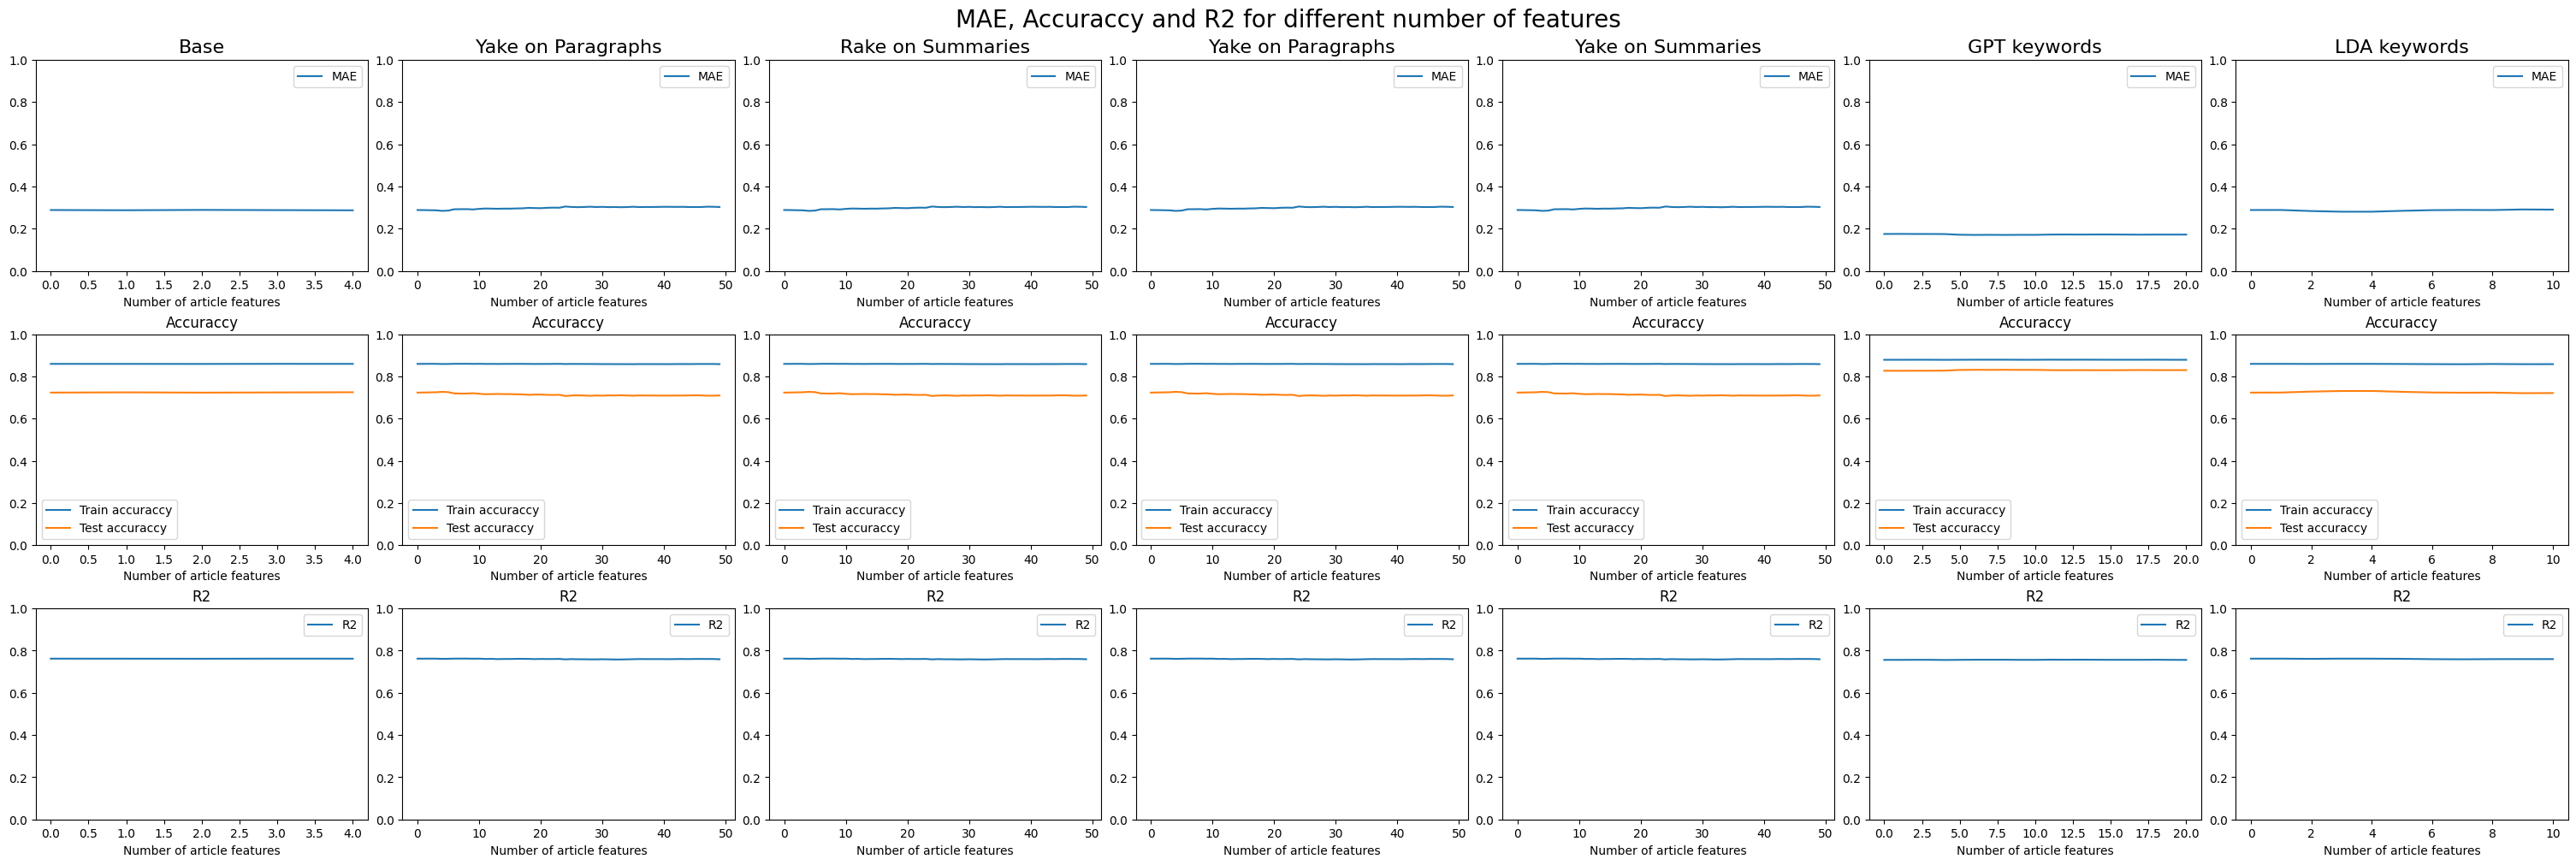

In [57]:
#plot MAE, accuraccy and R2 for different number of features [Base]
figure, axis = plt.subplots(3, 7, figsize=(30, 10), constrained_layout=True)

axis[0,0].plot(base_mae_values, label='MAE')
axis[2,0].plot(base_r2_values, label='R2')
axis[1,0].plot(base_train_accuracy, label='Train accuraccy')
axis[1,0].plot(base_test_accuracy, label='Test accuraccy')
axis[0,0].legend()
axis[1,0].legend()
axis[2,0].legend()
axis[0,0].set_title('MAE')
axis[1,0].set_title('Accuraccy')
axis[2,0].set_title('R2')
axis[0,0].set_xlabel('Number of article features')
axis[1,0].set_xlabel('Number of article features')
axis[2,0].set_xlabel('Number of article features')
axis[0,0].set_ylim(0, 1)
axis[1,0].set_ylim(0, 1)
axis[2,0].set_ylim(0, 1)
axis[0,0].set_title('Base', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Paragraphs]
axis[0,1].plot(yp_mae_values, label='MAE')
axis[2,1].plot(yp_r2_values, label='R2')
axis[1,1].plot(yp_train_accuracy, label='Train accuraccy')
axis[1,1].plot(yp_test_accuracy, label='Test accuraccy')
axis[0,1].legend()
axis[1,1].legend()
axis[2,1].legend()
axis[0,1].set_title('MAE')
axis[1,1].set_title('Accuraccy')
axis[2,1].set_title('R2')
axis[0,1].set_xlabel('Number of article features')
axis[1,1].set_xlabel('Number of article features')
axis[2,1].set_xlabel('Number of article features')
axis[0,1].set_ylim(0, 1)
axis[1,1].set_ylim(0, 1)
axis[2,1].set_ylim(0, 1)
axis[0,1].set_title('Yake on Paragraphs', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Summary]
axis[0,2].plot(rs_mae_values, label='MAE')
axis[2,2].plot(rs_r2_values, label='R2')
axis[1,2].plot(rs_train_accuracy, label='Train accuraccy')
axis[1,2].plot(rs_test_accuracy, label='Test accuraccy')
axis[0,2].legend()
axis[1,2].legend()
axis[2,2].legend()
axis[0,2].set_title('MAE')
axis[1,2].set_title('Accuraccy')
axis[2,2].set_title('R2')
axis[0,2].set_xlabel('Number of article features')
axis[1,2].set_xlabel('Number of article features')
axis[2,2].set_xlabel('Number of article features')
axis[0,2].set_ylim(0, 1)
axis[1,2].set_ylim(0, 1)
axis[2,2].set_ylim(0, 1)
axis[0,2].set_title('Rake on Summaries', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Paragraphs]
axis[0,3].plot(yp_mae_values, label='MAE')
axis[2,3].plot(yp_r2_values, label='R2')
axis[1,3].plot(yp_train_accuracy, label='Train accuraccy')
axis[1,3].plot(yp_test_accuracy, label='Test accuraccy')
axis[0,3].legend()
axis[1,3].legend()
axis[2,3].legend()
axis[0,3].set_title('MAE')
axis[1,3].set_title('Accuraccy')
axis[2,3].set_title('R2')
axis[0,3].set_xlabel('Number of article features')
axis[1,3].set_xlabel('Number of article features')
axis[2,3].set_xlabel('Number of article features')
axis[0,3].set_ylim(0, 1)
axis[1,3].set_ylim(0, 1)
axis[2,3].set_ylim(0, 1)
axis[0,3].set_title('Yake on Paragraphs', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Summary]
axis[0,4].plot(ys_mae_values, label='MAE')
axis[2,4].plot(ys_r2_values, label='R2')
axis[1,4].plot(ys_train_accuracy, label='Train accuraccy')
axis[1,4].plot(ys_test_accuracy, label='Test accuraccy')
axis[0,4].legend()
axis[1,4].legend()
axis[2,4].legend()
axis[0,4].set_title('MAE')
axis[1,4].set_title('Accuraccy')
axis[2,4].set_title('R2')
axis[0,4].set_xlabel('Number of article features')
axis[1,4].set_xlabel('Number of article features')
axis[2,4].set_xlabel('Number of article features')
axis[0,4].set_ylim(0, 1)
axis[1,4].set_ylim(0, 1)
axis[2,4].set_ylim(0, 1)
axis[0,4].set_title('Yake on Summaries', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [GPT]
axis[0,5].plot(gpt_mae_values, label='MAE')
axis[2,5].plot(gpt_r2_values, label='R2')
axis[1,5].plot(gpt_train_accuracy, label='Train accuraccy')
axis[1,5].plot(gpt_test_accuracy, label='Test accuraccy')
axis[0,5].legend()
axis[1,5].legend()
axis[2,5].legend()
axis[0,5].set_title('MAE')
axis[1,5].set_title('Accuraccy')
axis[2,5].set_title('R2')
axis[0,5].set_xlabel('Number of article features')
axis[1,5].set_xlabel('Number of article features')
axis[2,5].set_xlabel('Number of article features')
axis[0,5].set_ylim(0, 1)
axis[1,5].set_ylim(0, 1)
axis[2,5].set_ylim(0, 1)
axis[0,5].set_title('GPT keywords', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20);

#plot MAE, accuraccy and R2 for different number of features [LDA]
axis[0,6].plot(lda_mae_values, label='MAE')
axis[2,6].plot(lda_r2_values, label='R2')
axis[1,6].plot(lda_train_accuracy, label='Train accuraccy')
axis[1,6].plot(lda_test_accuracy, label='Test accuraccy')
axis[0,6].legend()
axis[1,6].legend()
axis[2,6].legend()
axis[0,6].set_title('MAE')
axis[1,6].set_title('Accuraccy')
axis[2,6].set_title('R2')
axis[0,6].set_xlabel('Number of article features')
axis[1,6].set_xlabel('Number of article features')
axis[2,6].set_xlabel('Number of article features')
axis[0,6].set_ylim(0, 1)
axis[1,6].set_ylim(0, 1)
axis[2,6].set_ylim(0, 1)
axis[0,6].set_title('LDA keywords', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20);

## Only Topics

In [58]:
base_mae_values_articles, base_r2_values_articles, base_train_accuracy_articles, base_test_accuracy_articles = train_model_only_articles_logistic(news_features_base)
rp_mae_values_articles, rp_r2_values_articles, rp_train_accuracy_articles, rp_test_accuracy_articles = train_model_only_articles_logistic(news_features_rp)
rs_mae_values_articles, rs_r2_values_articles, rs_train_accuracy_articles, rs_test_accuracy_articles = train_model_only_articles_logistic(news_features_rs)
rs_mae_values_articles, rs_r2_values_articles, rs_train_accuracy_articles, rs_test_accuracy_articles = train_model_only_articles_logistic(news_features_rs)
yp_mae_values_articles, yp_r2_values_articles, yp_train_accuracy_articles, yp_test_accuracy_articles = train_model_only_articles_logistic(news_features_yp)
ys_mae_values_articles, ys_r2_values_articles, ys_train_accuracy_articles, ys_test_accuracy_articles = train_model_only_articles_logistic(news_features_ys)
gpt_mae_values_articles, gpt_r2_values_articles, gpt_train_accuracy_articles, gpt_test_accuracy_articles = train_model_only_articles_logistic(news_features_gpt)
lda_mae_values_articles, lda_r2_values_articles, lda_train_accuracy_articles, lda_test_accuracy_articles = train_model_only_articles_logistic(news_features_lda)

NameError: name 'train_model_only_articles_logistic' is not defined

### Plotting only topics

Text(0.5, 0.98, 'MAE, Accuraccy and R2 for different number of features')

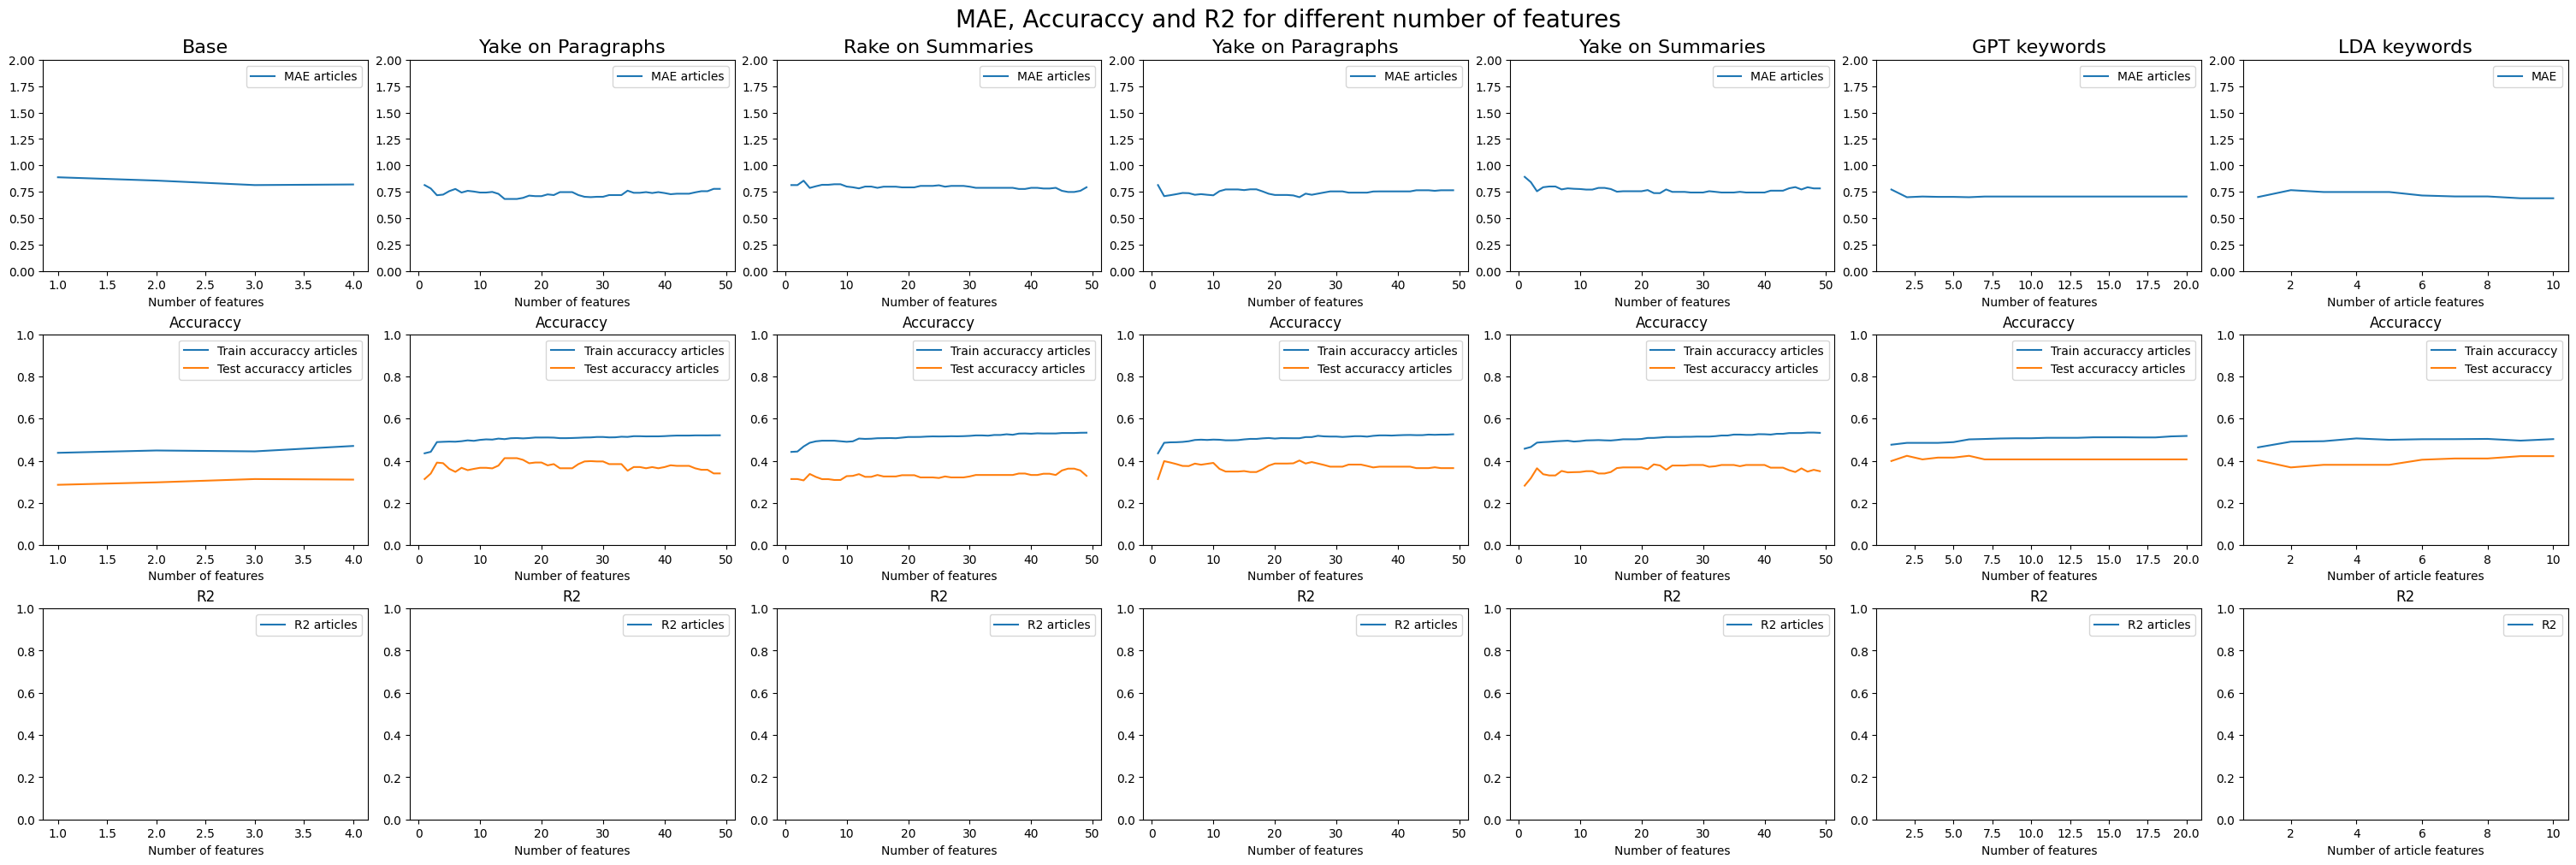

In [ ]:
#offset xvals for plotting
base_article_xvals = [i for i in range(1, 5)]
article_xvals = [i for i in range(1, 50)]
gpt_article_xvals = [i for i in range(1, 21)]
lda_article_xvals = [i for i in range(1, 11)]

#plot MAE, accuraccy and R2 for different number of features [Base]
figure, axis = plt.subplots(3, 7, figsize=(30, 10), constrained_layout=True)

axis[0,0].plot(base_article_xvals, base_mae_values_articles, label='MAE articles')
axis[2,0].plot(base_article_xvals, base_r2_values_articles, label='R2 articles')
axis[1,0].plot(base_article_xvals, base_train_accuracy_articles, label='Train accuraccy articles')
axis[1,0].plot(base_article_xvals, base_test_accuracy_articles, label='Test accuraccy articles')
axis[0,0].legend()
axis[1,0].legend()
axis[2,0].legend()
axis[0,0].set_title('MAE')
axis[1,0].set_title('Accuraccy')
axis[2,0].set_title('R2')
axis[0,0].set_xlabel('Number of features')
axis[1,0].set_xlabel('Number of features')
axis[2,0].set_xlabel('Number of features')
axis[0,0].set_ylim(0, 2)
axis[1,0].set_ylim(0, 1)
axis[2,0].set_ylim(0, 1)
axis[0,0].set_title('Base', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Paragraphs]
axis[0,1].plot(article_xvals, rp_mae_values_articles, label='MAE articles')
axis[2,1].plot(article_xvals, rp_r2_values_articles, label='R2 articles')
axis[1,1].plot(article_xvals, rp_train_accuracy_articles, label='Train accuraccy articles')
axis[1,1].plot(article_xvals, rp_test_accuracy_articles, label='Test accuraccy articles')
axis[0,1].legend()
axis[1,1].legend()
axis[2,1].legend()
axis[0,1].set_title('MAE')
axis[1,1].set_title('Accuraccy')
axis[2,1].set_title('R2')
axis[0,1].set_xlabel('Number of features')
axis[1,1].set_xlabel('Number of features')
axis[2,1].set_xlabel('Number of features')
axis[0,1].set_ylim(0, 2)
axis[1,1].set_ylim(0, 1)
axis[2,1].set_ylim(0, 1)
axis[0,1].set_title('Yake on Paragraphs', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Summary]
axis[0,2].plot(article_xvals, rs_mae_values_articles, label='MAE articles')
axis[2,2].plot(article_xvals, rs_r2_values_articles, label='R2 articles')
axis[1,2].plot(article_xvals, rs_train_accuracy_articles, label='Train accuraccy articles')
axis[1,2].plot(article_xvals, rs_test_accuracy_articles, label='Test accuraccy articles')
axis[0,2].legend()
axis[1,2].legend()
axis[2,2].legend()
axis[0,2].set_title('MAE')
axis[1,2].set_title('Accuraccy')
axis[2,2].set_title('R2')
axis[0,2].set_xlabel('Number of features')
axis[1,2].set_xlabel('Number of features')
axis[2,2].set_xlabel('Number of features')
axis[0,2].set_ylim(0, 2)
axis[1,2].set_ylim(0, 1)
axis[2,2].set_ylim(0, 1)
axis[0,2].set_title('Rake on Summaries', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Paragraphs]
axis[0,3].plot(article_xvals, yp_mae_values_articles, label='MAE articles')
axis[2,3].plot(article_xvals, yp_r2_values_articles, label='R2 articles')
axis[1,3].plot(article_xvals, yp_train_accuracy_articles, label='Train accuraccy articles')
axis[1,3].plot(article_xvals, yp_test_accuracy_articles, label='Test accuraccy articles')
axis[0,3].legend()
axis[1,3].legend()
axis[2,3].legend()
axis[0,3].set_title('MAE')
axis[1,3].set_title('Accuraccy')
axis[2,3].set_title('R2')
axis[0,3].set_xlabel('Number of features')
axis[1,3].set_xlabel('Number of features')
axis[2,3].set_xlabel('Number of features')
axis[0,3].set_ylim(0, 2)
axis[1,3].set_ylim(0, 1)
axis[2,3].set_ylim(0, 1)
axis[0,3].set_title('Yake on Paragraphs', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Summary]
axis[0,4].plot(article_xvals, ys_mae_values_articles, label='MAE articles')
axis[2,4].plot(article_xvals, ys_r2_values_articles, label='R2 articles')
axis[1,4].plot(article_xvals, ys_train_accuracy_articles, label='Train accuraccy articles')
axis[1,4].plot(article_xvals, ys_test_accuracy_articles, label='Test accuraccy articles')
axis[0,4].legend()
axis[1,4].legend()
axis[2,4].legend()
axis[0,4].set_title('MAE')
axis[1,4].set_title('Accuraccy')
axis[2,4].set_title('R2')
axis[0,4].set_xlabel('Number of features')
axis[1,4].set_xlabel('Number of features')
axis[2,4].set_xlabel('Number of features')
axis[0,4].set_ylim(0, 2)
axis[1,4].set_ylim(0, 1)
axis[2,4].set_ylim(0, 1)
axis[0,4].set_title('Yake on Summaries', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [GPT]
axis[0,5].plot(gpt_article_xvals, gpt_mae_values_articles, label='MAE articles')
axis[2,5].plot(gpt_article_xvals, gpt_r2_values_articles, label='R2 articles')
axis[1,5].plot(gpt_article_xvals, gpt_train_accuracy_articles, label='Train accuraccy articles')
axis[1,5].plot(gpt_article_xvals, gpt_test_accuracy_articles, label='Test accuraccy articles')
axis[0,5].legend()
axis[1,5].legend()
axis[2,5].legend()
axis[0,5].set_title('MAE')
axis[1,5].set_title('Accuraccy')
axis[2,5].set_title('R2')
axis[0,5].set_xlabel('Number of features')
axis[1,5].set_xlabel('Number of features')
axis[2,5].set_xlabel('Number of features')
axis[0,5].set_ylim(0, 2)
axis[1,5].set_ylim(0, 1)
axis[2,5].set_ylim(0, 1)
axis[0,5].set_title('GPT keywords', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20);

#plot MAE, accuraccy and R2 for different number of features [LDA]
axis[0,6].plot(lda_article_xvals, lda_mae_values_articles, label='MAE')
axis[2,6].plot(lda_article_xvals, lda_r2_values_articles, label='R2')
axis[1,6].plot(lda_article_xvals, lda_train_accuracy_articles, label='Train accuraccy')
axis[1,6].plot(lda_article_xvals, lda_test_accuracy_articles, label='Test accuraccy')
axis[0,6].legend()
axis[1,6].legend()
axis[2,6].legend()
axis[0,6].set_title('MAE')
axis[1,6].set_title('Accuraccy')
axis[2,6].set_title('R2')
axis[0,6].set_xlabel('Number of article features')
axis[1,6].set_xlabel('Number of article features')
axis[2,6].set_xlabel('Number of article features')
axis[0,6].set_ylim(0, 2)
axis[1,6].set_ylim(0, 1)
axis[2,6].set_ylim(0, 1)
axis[0,6].set_title('LDA keywords', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20)

## Combined plot

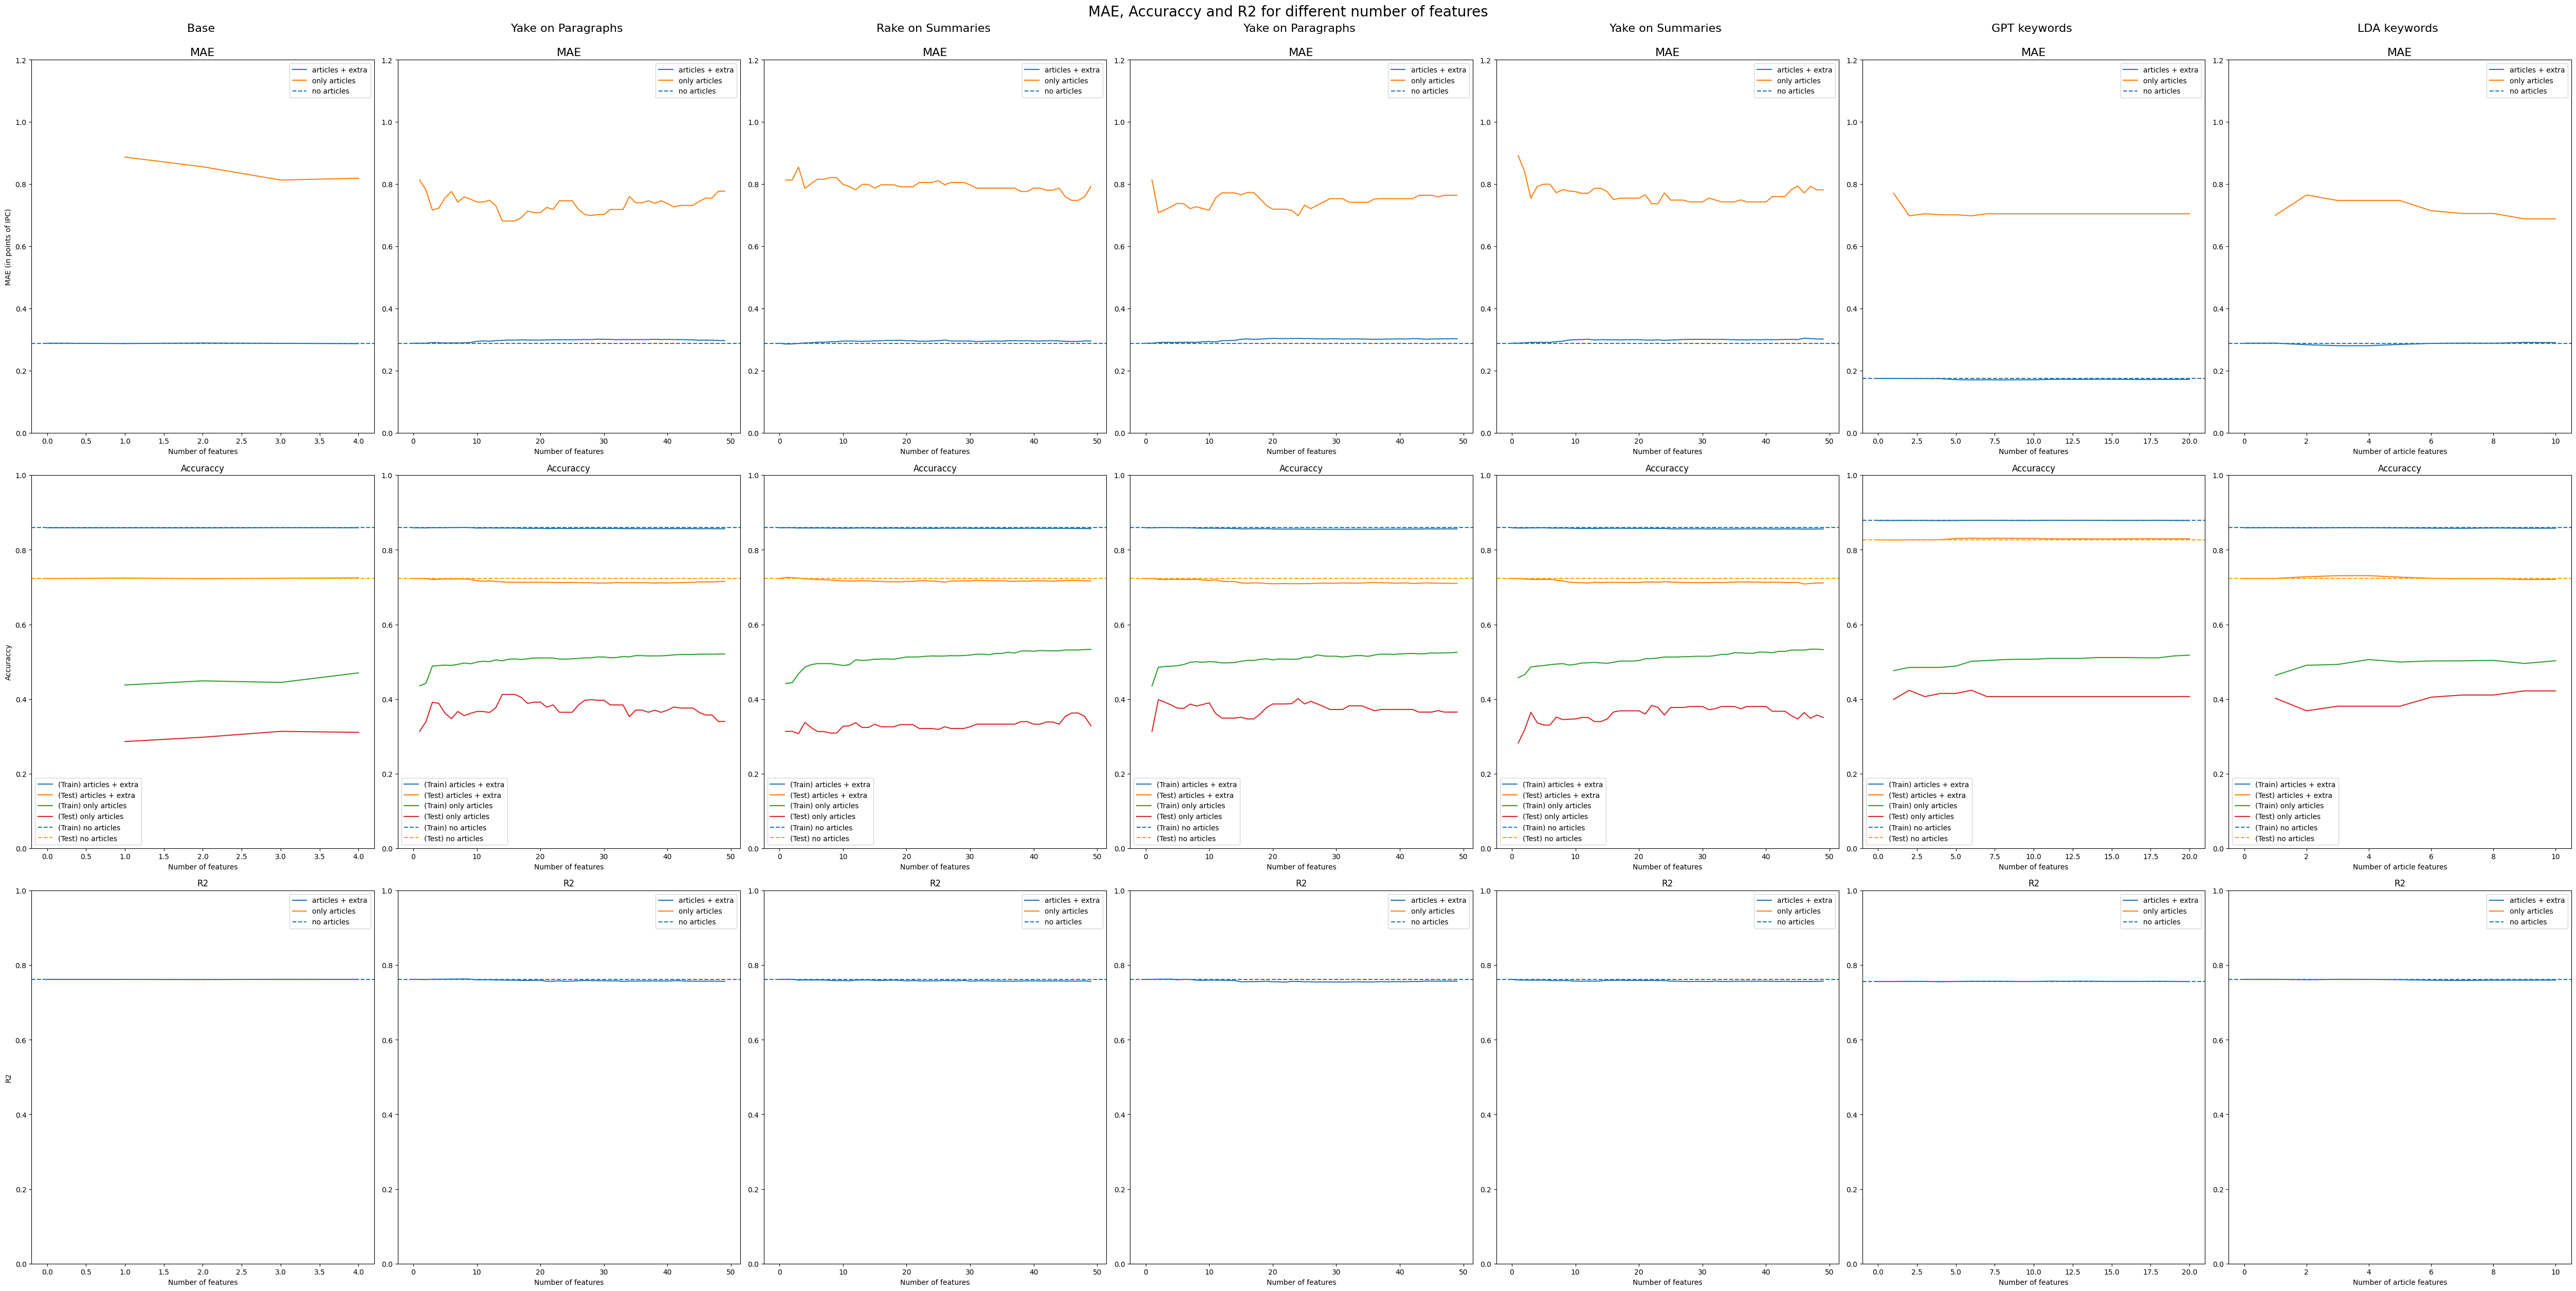

In [ ]:
#offset xvals for plotting
base_article_xvals = [i for i in range(1, 5)]
article_xvals = [i for i in range(1, 50)]
gpt_article_xvals = [i for i in range(1, 21)]
lda_article_xvals = [i for i in range(1, 11)]

#plot MAE, accuraccy and R2 for different number of features [Base]
figure, axis = plt.subplots(3, 7, figsize=(50, 25), constrained_layout=True)

axis[0,0].plot(base_mae_values, label='articles + extra')
axis[2,0].plot(base_r2_values, label='articles + extra')
axis[1,0].plot(base_train_accuracy, label='(Train) articles + extra')
axis[1,0].plot(base_test_accuracy, label='(Test) articles + extra')

axis[0,0].plot(base_article_xvals, base_mae_values_articles, label='only articles')
axis[2,0].plot(base_article_xvals, base_r2_values_articles, label='only articles')
axis[1,0].plot(base_article_xvals, base_train_accuracy_articles, label='(Train) only articles')
axis[1,0].plot(base_article_xvals, base_test_accuracy_articles, label='(Test) only articles')

axis[0,0].axhline(base_mae_values[0], linestyle='--', label='no articles')
axis[2,0].axhline(base_r2_values[0], linestyle='--', label='no articles')
axis[1,0].axhline(base_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,0].axhline(base_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,0].legend()
axis[1,0].legend()
axis[2,0].legend()
axis[1,0].set_title('Accuraccy')
axis[2,0].set_title('R2')
axis[0,0].set_xlabel('Number of features')
axis[1,0].set_xlabel('Number of features')
axis[2,0].set_xlabel('Number of features')
axis[0,0].set_ylabel('MAE (in points of IPC)')
axis[1,0].set_ylabel('Accuraccy')
axis[2,0].set_ylabel('R2')
axis[0,0].set_ylim(0, 1.2)
axis[1,0].set_ylim(0, 1)
axis[2,0].set_ylim(0, 1)
axis[0,0].set_title('Base \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Paragraphs]
axis[0,1].plot(rp_mae_values, label='articles + extra')
axis[2,1].plot(rp_r2_values, label='articles + extra')
axis[1,1].plot(rp_train_accuracy, label='(Train) articles + extra')
axis[1,1].plot(rp_test_accuracy, label='(Test) articles + extra')

axis[0,1].plot(article_xvals, rp_mae_values_articles, label='only articles')
axis[2,1].plot(article_xvals, rp_r2_values_articles, label='only articles')
axis[1,1].plot(article_xvals, rp_train_accuracy_articles, label='(Train) only articles')
axis[1,1].plot(article_xvals, rp_test_accuracy_articles, label='(Test) only articles')

axis[0,1].axhline(rp_mae_values[0], linestyle='--', label='no articles')
axis[2,1].axhline(rp_r2_values[0], linestyle='--', label='no articles')
axis[1,1].axhline(rp_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,1].axhline(rp_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,1].legend()
axis[1,1].legend()
axis[2,1].legend()
axis[1,1].set_title('Accuraccy')
axis[2,1].set_title('R2')
axis[0,1].set_xlabel('Number of features')
axis[1,1].set_xlabel('Number of features')
axis[2,1].set_xlabel('Number of features')
axis[0,1].set_ylim(0, 1.2)
axis[1,1].set_ylim(0, 1)
axis[2,1].set_ylim(0, 1)
axis[0,1].set_title('Yake on Paragraphs \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Summary]
axis[0,2].plot(rs_mae_values, label='articles + extra')
axis[2,2].plot(rs_r2_values, label='articles + extra')
axis[1,2].plot(rs_train_accuracy, label='(Train) articles + extra')
axis[1,2].plot(rs_test_accuracy, label='(Test) articles + extra')

axis[0,2].plot(article_xvals, rs_mae_values_articles, label='only articles')
axis[2,2].plot(article_xvals, rs_r2_values_articles, label='only articles')
axis[1,2].plot(article_xvals, rs_train_accuracy_articles, label='(Train) only articles')
axis[1,2].plot(article_xvals, rs_test_accuracy_articles, label='(Test) only articles')

axis[0,2].axhline(rs_mae_values[0], linestyle='--', label='no articles')
axis[2,2].axhline(rs_r2_values[0], linestyle='--', label='no articles')
axis[1,2].axhline(rs_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,2].axhline(rs_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,2].legend()
axis[1,2].legend()
axis[2,2].legend()
axis[1,2].set_title('Accuraccy')
axis[2,2].set_title('R2')
axis[0,2].set_xlabel('Number of features')
axis[1,2].set_xlabel('Number of features')
axis[2,2].set_xlabel('Number of features')
axis[0,2].set_ylim(0, 1.2)
axis[1,2].set_ylim(0, 1)
axis[2,2].set_ylim(0, 1)
axis[0,2].set_title('Rake on Summaries \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Paragraphs]
axis[0,3].plot(yp_mae_values, label='articles + extra')
axis[2,3].plot(yp_r2_values, label='articles + extra')
axis[1,3].plot(yp_train_accuracy, label='(Train) articles + extra')
axis[1,3].plot(yp_test_accuracy, label='(Test) articles + extra')

axis[0,3].plot(article_xvals, yp_mae_values_articles, label='only articles')
axis[2,3].plot(article_xvals, yp_r2_values_articles, label='only articles')
axis[1,3].plot(article_xvals, yp_train_accuracy_articles, label='(Train) only articles')
axis[1,3].plot(article_xvals, yp_test_accuracy_articles, label='(Test) only articles')

axis[0,3].axhline(yp_mae_values[0], linestyle='--', label='no articles')
axis[2,3].axhline(yp_r2_values[0], linestyle='--', label='no articles')
axis[1,3].axhline(yp_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,3].axhline(yp_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,3].legend()
axis[1,3].legend()
axis[2,3].legend()
axis[0,3].set_title('MAE')
axis[1,3].set_title('Accuraccy')
axis[2,3].set_title('R2')
axis[0,3].set_xlabel('Number of features')
axis[1,3].set_xlabel('Number of features')
axis[2,3].set_xlabel('Number of features')
axis[0,3].set_ylim(0, 1.2)
axis[1,3].set_ylim(0, 1)
axis[2,3].set_ylim(0, 1)
axis[0,3].set_title('Yake on Paragraphs \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Summary]
axis[0,4].plot(ys_mae_values, label='articles + extra')
axis[2,4].plot(ys_r2_values, label='articles + extra')
axis[1,4].plot(ys_train_accuracy, label='(Train) articles + extra')
axis[1,4].plot(ys_test_accuracy, label='(Test) articles + extra')

axis[0,4].plot(article_xvals, ys_mae_values_articles, label='only articles')
axis[2,4].plot(article_xvals, ys_r2_values_articles, label='only articles')
axis[1,4].plot(article_xvals, ys_train_accuracy_articles, label='(Train) only articles')
axis[1,4].plot(article_xvals, ys_test_accuracy_articles, label='(Test) only articles')

axis[0,4].axhline(ys_mae_values[0], linestyle='--', label='no articles')
axis[2,4].axhline(ys_r2_values[0], linestyle='--', label='no articles')
axis[1,4].axhline(ys_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,4].axhline(ys_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,4].legend()
axis[1,4].legend()
axis[2,4].legend()
axis[1,4].set_title('Accuraccy')
axis[2,4].set_title('R2')
axis[0,4].set_xlabel('Number of features')
axis[1,4].set_xlabel('Number of features')
axis[2,4].set_xlabel('Number of features')
axis[0,4].set_ylim(0, 1.2)
axis[1,4].set_ylim(0, 1)
axis[2,4].set_ylim(0, 1)
axis[0,4].set_title('Yake on Summaries \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [GPT]
axis[0,5].plot(gpt_mae_values, label='articles + extra')
axis[2,5].plot(gpt_r2_values, label='articles + extra')
axis[1,5].plot(gpt_train_accuracy, label='(Train) articles + extra')
axis[1,5].plot(gpt_test_accuracy, label='(Test) articles + extra')

axis[0,5].plot(gpt_article_xvals, gpt_mae_values_articles, label='only articles')
axis[2,5].plot(gpt_article_xvals, gpt_r2_values_articles, label='only articles')
axis[1,5].plot(gpt_article_xvals, gpt_train_accuracy_articles, label='(Train) only articles')
axis[1,5].plot(gpt_article_xvals, gpt_test_accuracy_articles, label='(Test) only articles')

#create horizontal lines for no articles to see if there is an improvement
axis[0,5].axhline(gpt_mae_values[0], linestyle='--', label='no articles')
axis[2,5].axhline(gpt_r2_values[0], linestyle='--', label='no articles')
axis[1,5].axhline(gpt_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,5].axhline(gpt_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,5].legend()
axis[1,5].legend()
axis[2,5].legend()
axis[1,5].set_title('Accuraccy')
axis[2,5].set_title('R2')
axis[0,5].set_xlabel('Number of features')
axis[1,5].set_xlabel('Number of features')
axis[2,5].set_xlabel('Number of features')
axis[0,5].set_ylim(0, 1.2)
axis[1,5].set_ylim(0, 1)
axis[2,5].set_ylim(0, 1)
axis[0,5].set_title('GPT keywords \n\nMAE', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20);

#plot MAE, accuraccy and R2 for different number of features [LDA]
axis[0,6].plot(lda_mae_values, label='articles + extra')
axis[2,6].plot(lda_r2_values, label='articles + extra')
axis[1,6].plot(lda_train_accuracy, label='(Train) articles + extra')
axis[1,6].plot(lda_test_accuracy, label='(Test) articles + extra')

axis[0,6].plot(lda_article_xvals, lda_mae_values_articles, label='only articles')
axis[2,6].plot(lda_article_xvals, lda_r2_values_articles, label='only articles')
axis[1,6].plot(lda_article_xvals, lda_train_accuracy_articles, label='(Train) only articles')
axis[1,6].plot(lda_article_xvals, lda_test_accuracy_articles, label='(Test) only articles')

#create horizontal lines for no articles to see if there is an improvement
axis[0,6].axhline(lda_mae_values[0], linestyle='--', label='no articles')
axis[2,6].axhline(lda_r2_values[0], linestyle='--', label='no articles')
axis[1,6].axhline(lda_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,6].axhline(lda_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,6].legend()
axis[1,6].legend()
axis[2,6].legend()
axis[1,6].set_title('Accuraccy')
axis[2,6].set_title('R2')
axis[0,6].set_xlabel('Number of article features')
axis[1,6].set_xlabel('Number of article features')
axis[2,6].set_xlabel('Number of article features')
axis[0,6].set_ylim(0, 1.2)
axis[1,6].set_ylim(0, 1)
axis[2,6].set_ylim(0, 1)
axis[0,6].set_title('LDA keywords \n\nMAE', fontsize=16);

plt.savefig('bigone.png', format='png', dpi=100)

# OLS

## Topics + Baseline features

### Running models

In [104]:
base_mae_values, base_r2_values, base_train_accuracy, base_test_accuracy = train_model_OLS(news_features_base)
lda_mae_values, lda_r2_values, lda_train_accuracy, lda_test_accuracy = train_model_OLS(news_features_lda)
rp_mae_values, rp_r2_values, rp_train_accuracy, rp_test_accuracy = train_model_OLS(news_features_rp)
rs_mae_values, rs_r2_values, rs_train_accuracy, rs_test_accuracy = train_model_OLS(news_features_rs)
yp_mae_values, yp_r2_values, yp_train_accuracy, yp_test_accuracy = train_model_OLS(news_features_yp)
ys_mae_values, ys_r2_values, ys_train_accuracy, ys_test_accuracy = train_model_OLS(news_features_ys)
gpt_mae_values, gpt_r2_values, gpt_train_accuracy, gpt_test_accuracy = train_model_OLS(news_features_gpt)

Start: -10, End: -4
Number of features: 5
Mean MAE: 0.29
Mean R2: 0.76
Mean train accuraccy: 0.86
Mean test accuraccy: 0.72
Mean train accuraccy: 0.8591272697129231
Mean test accuraccy: 0.7230177059276367
-------------------------
Start: -10, End: -3
Number of features: 6
Mean MAE: 0.29
Mean R2: 0.76
Mean train accuraccy: 0.86
Mean test accuraccy: 0.72
Mean train accuraccy: 0.8590426241402751
Mean test accuraccy: 0.7242494226327945
-------------------------
Start: -10, End: -2
Number of features: 7
Mean MAE: 0.29
Mean R2: 0.76
Mean train accuraccy: 0.86
Mean test accuraccy: 0.72
Mean train accuraccy: 0.8588451164867085
Mean test accuraccy: 0.7228637413394919
-------------------------
Start: -10, End: -1
Number of features: 8
Mean MAE: 0.29
Mean R2: 0.76
Mean train accuraccy: 0.86
Mean test accuraccy: 0.72
Mean train accuraccy: 0.8593017006545345
Mean test accuraccy: 0.7237875288683603
-------------------------
Start: -10, End: 0
Number of features: 9
Mean MAE: 0.29
Mean R2: 0.76
Mean t

### plotting topics + baseline features

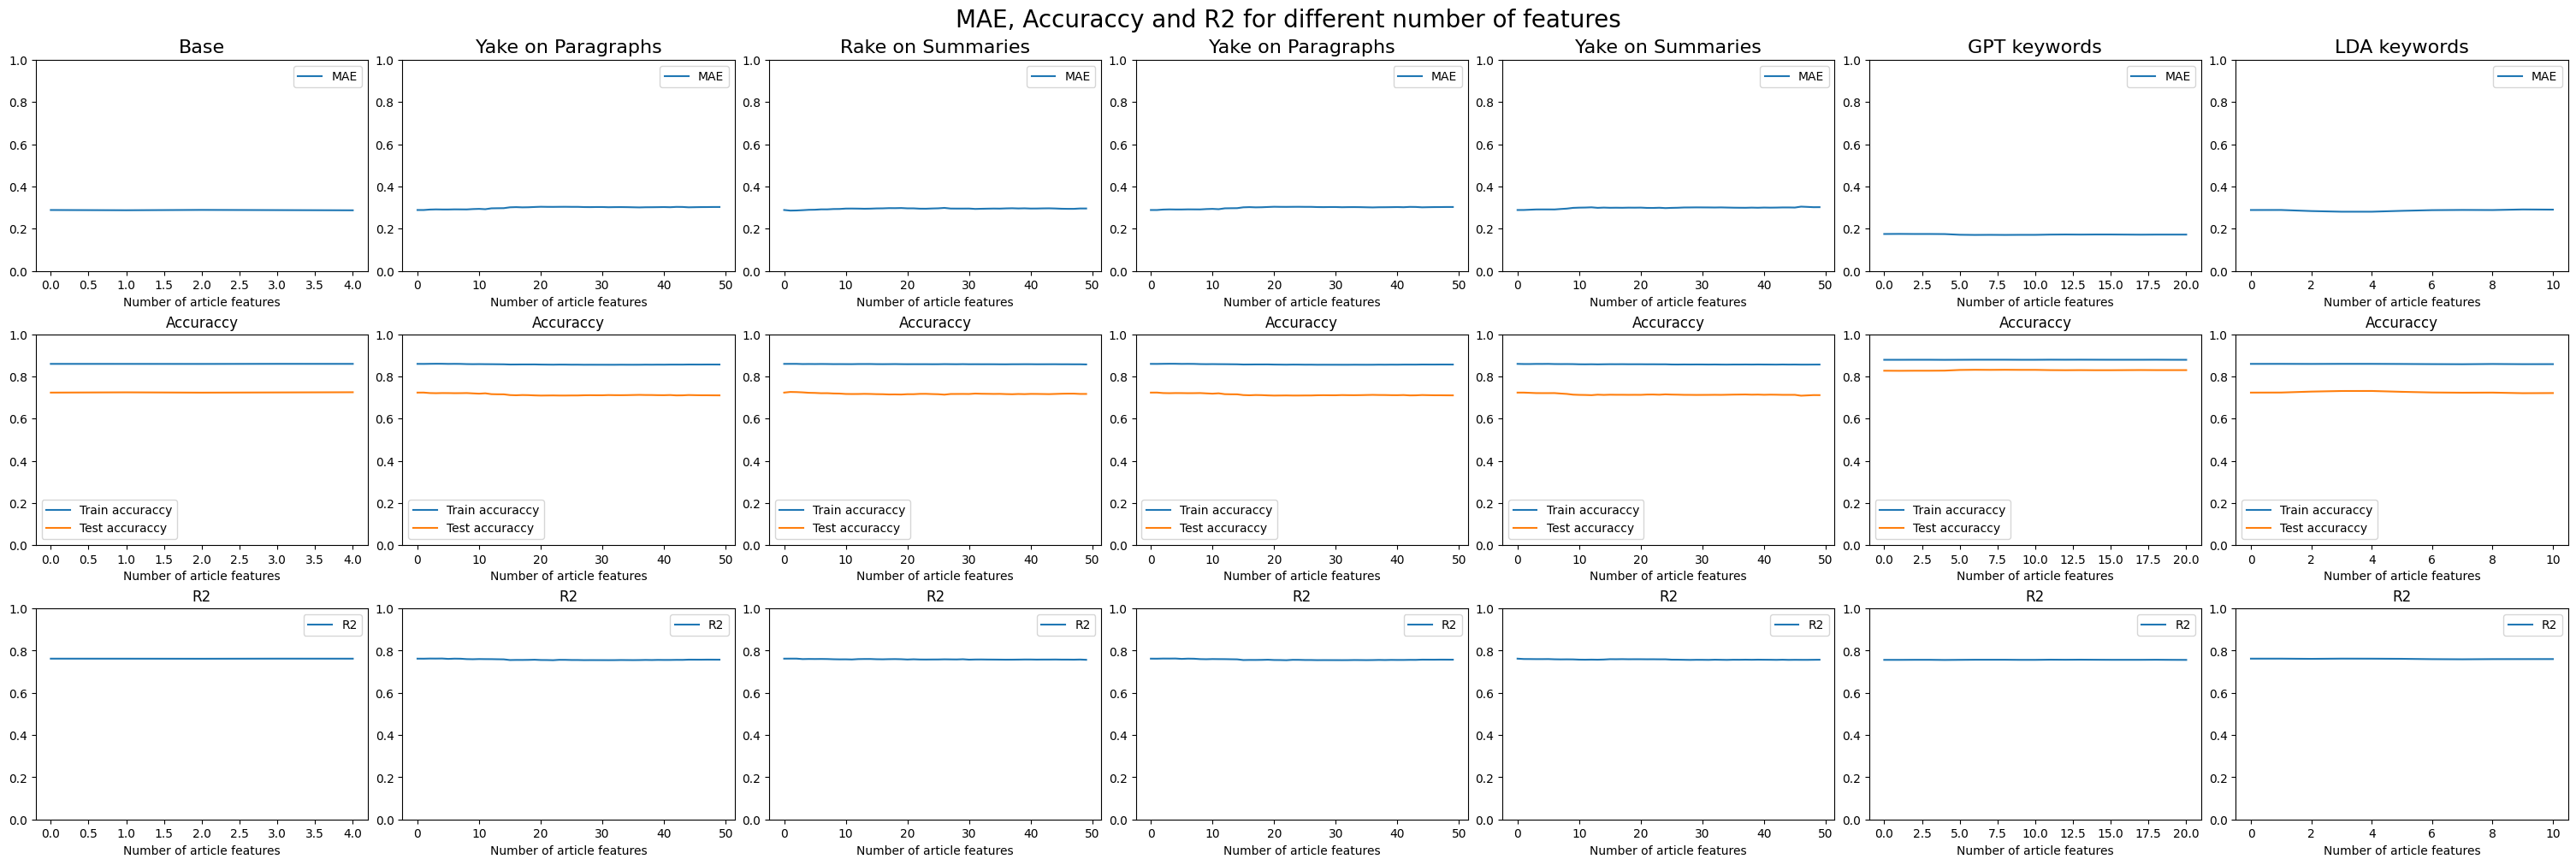

In [105]:
#plot MAE, accuraccy and R2 for different number of features [Base]
figure, axis = plt.subplots(3, 7, figsize=(30, 10), constrained_layout=True)

axis[0,0].plot(base_mae_values, label='MAE')
axis[2,0].plot(base_r2_values, label='R2')
axis[1,0].plot(base_train_accuracy, label='Train accuraccy')
axis[1,0].plot(base_test_accuracy, label='Test accuraccy')
axis[0,0].legend()
axis[1,0].legend()
axis[2,0].legend()
axis[0,0].set_title('MAE')
axis[1,0].set_title('Accuraccy')
axis[2,0].set_title('R2')
axis[0,0].set_xlabel('Number of article features')
axis[1,0].set_xlabel('Number of article features')
axis[2,0].set_xlabel('Number of article features')
axis[0,0].set_ylim(0, 1)
axis[1,0].set_ylim(0, 1)
axis[2,0].set_ylim(0, 1)
axis[0,0].set_title('Base', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Paragraphs]
axis[0,1].plot(yp_mae_values, label='MAE')
axis[2,1].plot(yp_r2_values, label='R2')
axis[1,1].plot(yp_train_accuracy, label='Train accuraccy')
axis[1,1].plot(yp_test_accuracy, label='Test accuraccy')
axis[0,1].legend()
axis[1,1].legend()
axis[2,1].legend()
axis[0,1].set_title('MAE')
axis[1,1].set_title('Accuraccy')
axis[2,1].set_title('R2')
axis[0,1].set_xlabel('Number of article features')
axis[1,1].set_xlabel('Number of article features')
axis[2,1].set_xlabel('Number of article features')
axis[0,1].set_ylim(0, 1)
axis[1,1].set_ylim(0, 1)
axis[2,1].set_ylim(0, 1)
axis[0,1].set_title('Yake on Paragraphs', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Summary]
axis[0,2].plot(rs_mae_values, label='MAE')
axis[2,2].plot(rs_r2_values, label='R2')
axis[1,2].plot(rs_train_accuracy, label='Train accuraccy')
axis[1,2].plot(rs_test_accuracy, label='Test accuraccy')
axis[0,2].legend()
axis[1,2].legend()
axis[2,2].legend()
axis[0,2].set_title('MAE')
axis[1,2].set_title('Accuraccy')
axis[2,2].set_title('R2')
axis[0,2].set_xlabel('Number of article features')
axis[1,2].set_xlabel('Number of article features')
axis[2,2].set_xlabel('Number of article features')
axis[0,2].set_ylim(0, 1)
axis[1,2].set_ylim(0, 1)
axis[2,2].set_ylim(0, 1)
axis[0,2].set_title('Rake on Summaries', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Paragraphs]
axis[0,3].plot(yp_mae_values, label='MAE')
axis[2,3].plot(yp_r2_values, label='R2')
axis[1,3].plot(yp_train_accuracy, label='Train accuraccy')
axis[1,3].plot(yp_test_accuracy, label='Test accuraccy')
axis[0,3].legend()
axis[1,3].legend()
axis[2,3].legend()
axis[0,3].set_title('MAE')
axis[1,3].set_title('Accuraccy')
axis[2,3].set_title('R2')
axis[0,3].set_xlabel('Number of article features')
axis[1,3].set_xlabel('Number of article features')
axis[2,3].set_xlabel('Number of article features')
axis[0,3].set_ylim(0, 1)
axis[1,3].set_ylim(0, 1)
axis[2,3].set_ylim(0, 1)
axis[0,3].set_title('Yake on Paragraphs', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Summary]
axis[0,4].plot(ys_mae_values, label='MAE')
axis[2,4].plot(ys_r2_values, label='R2')
axis[1,4].plot(ys_train_accuracy, label='Train accuraccy')
axis[1,4].plot(ys_test_accuracy, label='Test accuraccy')
axis[0,4].legend()
axis[1,4].legend()
axis[2,4].legend()
axis[0,4].set_title('MAE')
axis[1,4].set_title('Accuraccy')
axis[2,4].set_title('R2')
axis[0,4].set_xlabel('Number of article features')
axis[1,4].set_xlabel('Number of article features')
axis[2,4].set_xlabel('Number of article features')
axis[0,4].set_ylim(0, 1)
axis[1,4].set_ylim(0, 1)
axis[2,4].set_ylim(0, 1)
axis[0,4].set_title('Yake on Summaries', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [GPT]
axis[0,5].plot(gpt_mae_values, label='MAE')
axis[2,5].plot(gpt_r2_values, label='R2')
axis[1,5].plot(gpt_train_accuracy, label='Train accuraccy')
axis[1,5].plot(gpt_test_accuracy, label='Test accuraccy')
axis[0,5].legend()
axis[1,5].legend()
axis[2,5].legend()
axis[0,5].set_title('MAE')
axis[1,5].set_title('Accuraccy')
axis[2,5].set_title('R2')
axis[0,5].set_xlabel('Number of article features')
axis[1,5].set_xlabel('Number of article features')
axis[2,5].set_xlabel('Number of article features')
axis[0,5].set_ylim(0, 1)
axis[1,5].set_ylim(0, 1)
axis[2,5].set_ylim(0, 1)
axis[0,5].set_title('GPT keywords', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20);

#plot MAE, accuraccy and R2 for different number of features [LDA]
axis[0,6].plot(lda_mae_values, label='MAE')
axis[2,6].plot(lda_r2_values, label='R2')
axis[1,6].plot(lda_train_accuracy, label='Train accuraccy')
axis[1,6].plot(lda_test_accuracy, label='Test accuraccy')
axis[0,6].legend()
axis[1,6].legend()
axis[2,6].legend()
axis[0,6].set_title('MAE')
axis[1,6].set_title('Accuraccy')
axis[2,6].set_title('R2')
axis[0,6].set_xlabel('Number of article features')
axis[1,6].set_xlabel('Number of article features')
axis[2,6].set_xlabel('Number of article features')
axis[0,6].set_ylim(0, 1)
axis[1,6].set_ylim(0, 1)
axis[2,6].set_ylim(0, 1)
axis[0,6].set_title('LDA keywords', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20);

## Only Topics

### Running models

In [107]:
base_mae_values_articles, base_r2_values_articles, base_train_accuracy_articles, base_test_accuracy_articles = train_model_only_articles_OLS(news_features_base)
rp_mae_values_articles, rp_r2_values_articles, rp_train_accuracy_articles, rp_test_accuracy_articles = train_model_only_articles_OLS(news_features_rp)
rs_mae_values_articles, rs_r2_values_articles, rs_train_accuracy_articles, rs_test_accuracy_articles = train_model_only_articles_OLS(news_features_rs)
rs_mae_values_articles, rs_r2_values_articles, rs_train_accuracy_articles, rs_test_accuracy_articles = train_model_only_articles_OLS(news_features_rs)
yp_mae_values_articles, yp_r2_values_articles, yp_train_accuracy_articles, yp_test_accuracy_articles = train_model_only_articles_OLS(news_features_yp)
ys_mae_values_articles, ys_r2_values_articles, ys_train_accuracy_articles, ys_test_accuracy_articles = train_model_only_articles_OLS(news_features_ys)
gpt_mae_values_articles, gpt_r2_values_articles, gpt_train_accuracy_articles, gpt_test_accuracy_articles = train_model_only_articles_OLS(news_features_gpt)
lda_mae_values_articles, lda_r2_values_articles, lda_train_accuracy_articles, lda_test_accuracy_articles = train_model_only_articles_OLS(news_features_lda)

Start: -4, End: -3
Number of features: 0
Mean MAE: 1.48
Mean R2: -0.95
Mean train accuraccy: 0.35
Mean test accuraccy: 0.18
Mean train accuraccy: 0.345786620073125
Mean test accuraccy: 0.18090839107005388
-------------------------
Start: -4, End: -2
Number of features: 1
Mean MAE: 1.29
Mean R2: -0.52
Mean train accuraccy: 0.40
Mean test accuraccy: 0.22
Mean train accuraccy: 0.3986398508471234
Mean test accuraccy: 0.22047729022324863
-------------------------
Start: -4, End: -1
Number of features: 2
Mean MAE: 1.54
Mean R2: -0.44
Mean train accuraccy: 0.41
Mean test accuraccy: 0.18
Mean train accuraccy: 0.4136719509844583
Mean test accuraccy: 0.17859892224788299
-------------------------
Start: -4, End: 0
Number of features: 3
Mean MAE: 1.27
Mean R2: -0.08
Mean train accuraccy: 0.46
Mean test accuraccy: 0.24
Mean train accuraccy: 0.4604651572626374
Mean test accuraccy: 0.23849114703618168
-------------------------

All MAE values: [1.4801089556342255, 1.290493323870055, 1.537061330835048

### Plotting only topics

Text(0.5, 0.98, 'MAE, Accuraccy and R2 for different number of features')

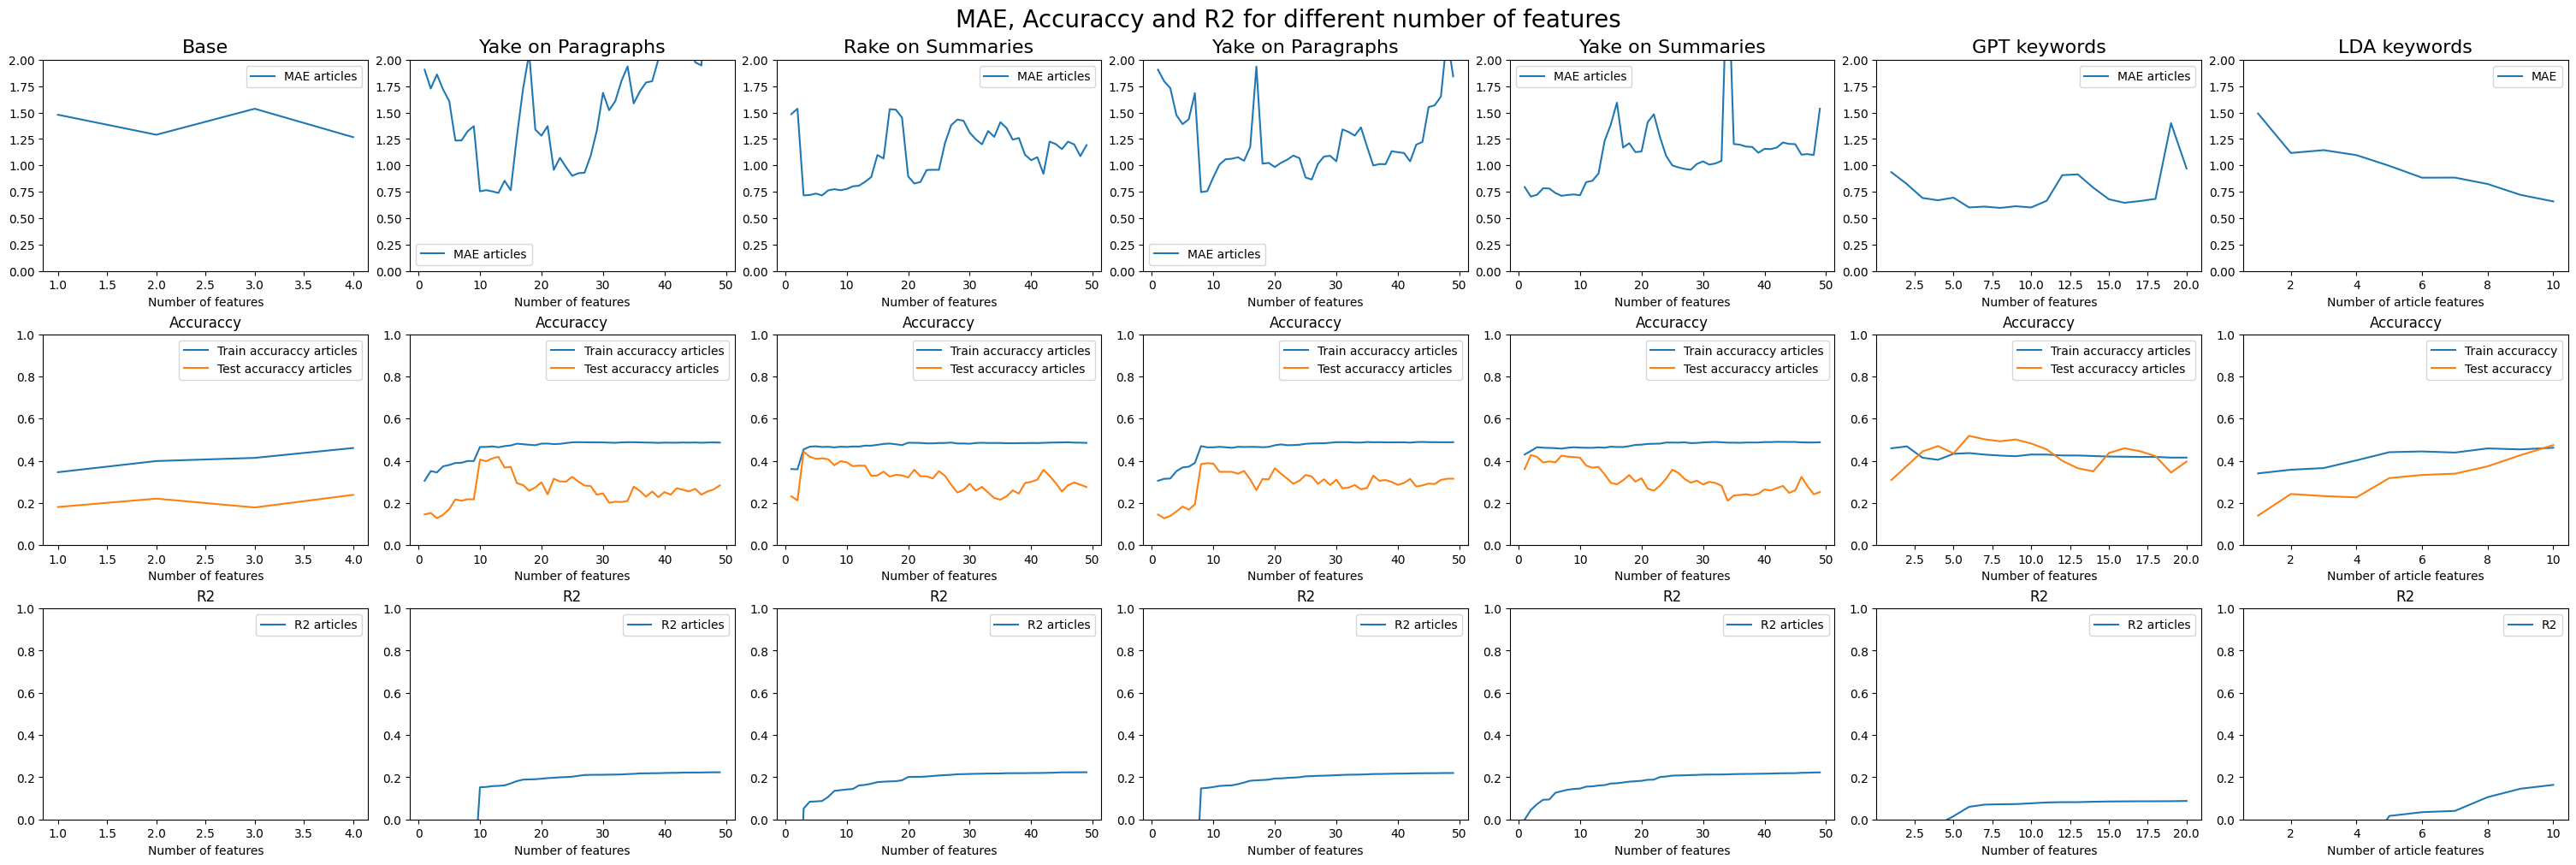

In [110]:
#offset xvals for plotting
base_article_xvals = [i for i in range(1, 5)]
article_xvals = [i for i in range(1, 50)]
gpt_article_xvals = [i for i in range(1, 21)]
lda_article_xvals = [i for i in range(1, 11)]

#plot MAE, accuraccy and R2 for different number of features [Base]
figure, axis = plt.subplots(3, 7, figsize=(30, 10), constrained_layout=True)

axis[0,0].plot(base_article_xvals, base_mae_values_articles, label='MAE articles')
axis[2,0].plot(base_article_xvals, base_r2_values_articles, label='R2 articles')
axis[1,0].plot(base_article_xvals, base_train_accuracy_articles, label='Train accuraccy articles')
axis[1,0].plot(base_article_xvals, base_test_accuracy_articles, label='Test accuraccy articles')
axis[0,0].legend()
axis[1,0].legend()
axis[2,0].legend()
axis[0,0].set_title('MAE')
axis[1,0].set_title('Accuraccy')
axis[2,0].set_title('R2')
axis[0,0].set_xlabel('Number of features')
axis[1,0].set_xlabel('Number of features')
axis[2,0].set_xlabel('Number of features')
axis[0,0].set_ylim(0, 2)
axis[1,0].set_ylim(0, 1)
axis[2,0].set_ylim(0, 1)
axis[0,0].set_title('Base', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Paragraphs]
axis[0,1].plot(article_xvals, rp_mae_values_articles, label='MAE articles')
axis[2,1].plot(article_xvals, rp_r2_values_articles, label='R2 articles')
axis[1,1].plot(article_xvals, rp_train_accuracy_articles, label='Train accuraccy articles')
axis[1,1].plot(article_xvals, rp_test_accuracy_articles, label='Test accuraccy articles')
axis[0,1].legend()
axis[1,1].legend()
axis[2,1].legend()
axis[0,1].set_title('MAE')
axis[1,1].set_title('Accuraccy')
axis[2,1].set_title('R2')
axis[0,1].set_xlabel('Number of features')
axis[1,1].set_xlabel('Number of features')
axis[2,1].set_xlabel('Number of features')
axis[0,1].set_ylim(0, 2)
axis[1,1].set_ylim(0, 1)
axis[2,1].set_ylim(0, 1)
axis[0,1].set_title('Yake on Paragraphs', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Summary]
axis[0,2].plot(article_xvals, rs_mae_values_articles, label='MAE articles')
axis[2,2].plot(article_xvals, rs_r2_values_articles, label='R2 articles')
axis[1,2].plot(article_xvals, rs_train_accuracy_articles, label='Train accuraccy articles')
axis[1,2].plot(article_xvals, rs_test_accuracy_articles, label='Test accuraccy articles')
axis[0,2].legend()
axis[1,2].legend()
axis[2,2].legend()
axis[0,2].set_title('MAE')
axis[1,2].set_title('Accuraccy')
axis[2,2].set_title('R2')
axis[0,2].set_xlabel('Number of features')
axis[1,2].set_xlabel('Number of features')
axis[2,2].set_xlabel('Number of features')
axis[0,2].set_ylim(0, 2)
axis[1,2].set_ylim(0, 1)
axis[2,2].set_ylim(0, 1)
axis[0,2].set_title('Rake on Summaries', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Paragraphs]
axis[0,3].plot(article_xvals, yp_mae_values_articles, label='MAE articles')
axis[2,3].plot(article_xvals, yp_r2_values_articles, label='R2 articles')
axis[1,3].plot(article_xvals, yp_train_accuracy_articles, label='Train accuraccy articles')
axis[1,3].plot(article_xvals, yp_test_accuracy_articles, label='Test accuraccy articles')
axis[0,3].legend()
axis[1,3].legend()
axis[2,3].legend()
axis[0,3].set_title('MAE')
axis[1,3].set_title('Accuraccy')
axis[2,3].set_title('R2')
axis[0,3].set_xlabel('Number of features')
axis[1,3].set_xlabel('Number of features')
axis[2,3].set_xlabel('Number of features')
axis[0,3].set_ylim(0, 2)
axis[1,3].set_ylim(0, 1)
axis[2,3].set_ylim(0, 1)
axis[0,3].set_title('Yake on Paragraphs', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Summary]
axis[0,4].plot(article_xvals, ys_mae_values_articles, label='MAE articles')
axis[2,4].plot(article_xvals, ys_r2_values_articles, label='R2 articles')
axis[1,4].plot(article_xvals, ys_train_accuracy_articles, label='Train accuraccy articles')
axis[1,4].plot(article_xvals, ys_test_accuracy_articles, label='Test accuraccy articles')
axis[0,4].legend()
axis[1,4].legend()
axis[2,4].legend()
axis[0,4].set_title('MAE')
axis[1,4].set_title('Accuraccy')
axis[2,4].set_title('R2')
axis[0,4].set_xlabel('Number of features')
axis[1,4].set_xlabel('Number of features')
axis[2,4].set_xlabel('Number of features')
axis[0,4].set_ylim(0, 2)
axis[1,4].set_ylim(0, 1)
axis[2,4].set_ylim(0, 1)
axis[0,4].set_title('Yake on Summaries', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [GPT]
axis[0,5].plot(gpt_article_xvals, gpt_mae_values_articles, label='MAE articles')
axis[2,5].plot(gpt_article_xvals, gpt_r2_values_articles, label='R2 articles')
axis[1,5].plot(gpt_article_xvals, gpt_train_accuracy_articles, label='Train accuraccy articles')
axis[1,5].plot(gpt_article_xvals, gpt_test_accuracy_articles, label='Test accuraccy articles')
axis[0,5].legend()
axis[1,5].legend()
axis[2,5].legend()
axis[0,5].set_title('MAE')
axis[1,5].set_title('Accuraccy')
axis[2,5].set_title('R2')
axis[0,5].set_xlabel('Number of features')
axis[1,5].set_xlabel('Number of features')
axis[2,5].set_xlabel('Number of features')
axis[0,5].set_ylim(0, 2)
axis[1,5].set_ylim(0, 1)
axis[2,5].set_ylim(0, 1)
axis[0,5].set_title('GPT keywords', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20);

#plot MAE, accuraccy and R2 for different number of features [LDA]
axis[0,6].plot(lda_article_xvals, lda_mae_values_articles, label='MAE')
axis[2,6].plot(lda_article_xvals, lda_r2_values_articles, label='R2')
axis[1,6].plot(lda_article_xvals, lda_train_accuracy_articles, label='Train accuraccy')
axis[1,6].plot(lda_article_xvals, lda_test_accuracy_articles, label='Test accuraccy')
axis[0,6].legend()
axis[1,6].legend()
axis[2,6].legend()
axis[0,6].set_title('MAE')
axis[1,6].set_title('Accuraccy')
axis[2,6].set_title('R2')
axis[0,6].set_xlabel('Number of article features')
axis[1,6].set_xlabel('Number of article features')
axis[2,6].set_xlabel('Number of article features')
axis[0,6].set_ylim(0, 2)
axis[1,6].set_ylim(0, 1)
axis[2,6].set_ylim(0, 1)
axis[0,6].set_title('LDA keywords', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20)

## Combined plot

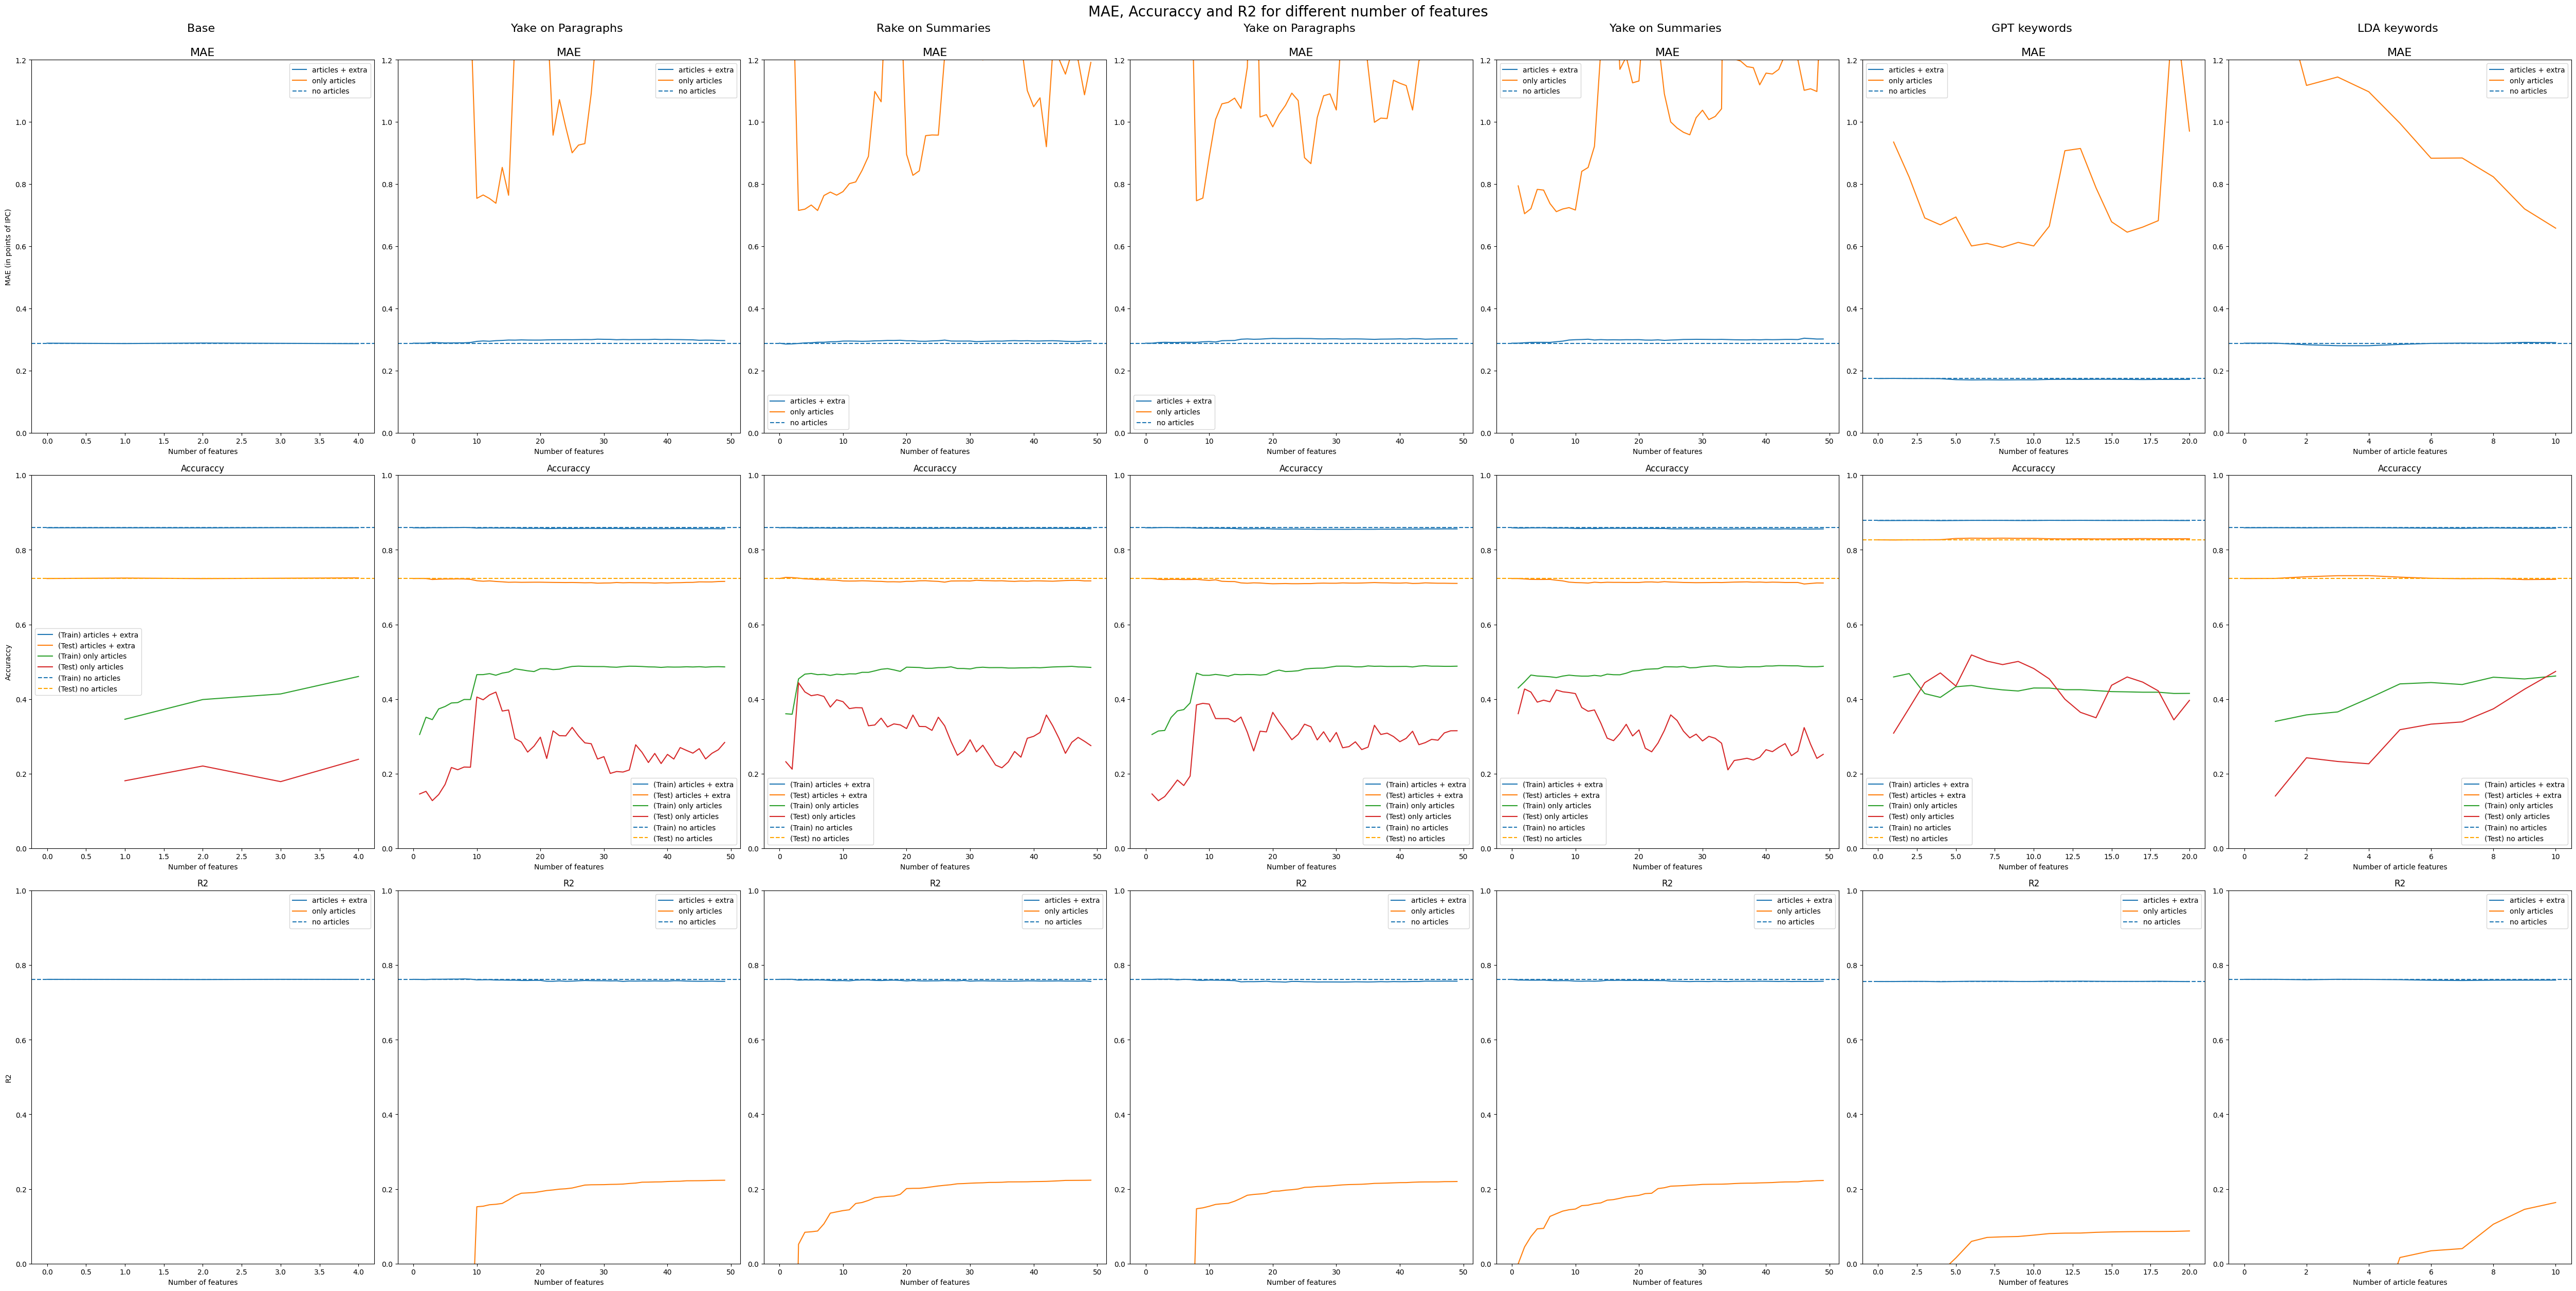

In [111]:
#offset xvals for plotting
base_article_xvals = [i for i in range(1, 5)]
article_xvals = [i for i in range(1, 50)]
gpt_article_xvals = [i for i in range(1, 21)]
lda_article_xvals = [i for i in range(1, 11)]

#plot MAE, accuraccy and R2 for different number of features [Base]
figure, axis = plt.subplots(3, 7, figsize=(50, 25), constrained_layout=True)

axis[0,0].plot(base_mae_values, label='articles + extra')
axis[2,0].plot(base_r2_values, label='articles + extra')
axis[1,0].plot(base_train_accuracy, label='(Train) articles + extra')
axis[1,0].plot(base_test_accuracy, label='(Test) articles + extra')

axis[0,0].plot(base_article_xvals, base_mae_values_articles, label='only articles')
axis[2,0].plot(base_article_xvals, base_r2_values_articles, label='only articles')
axis[1,0].plot(base_article_xvals, base_train_accuracy_articles, label='(Train) only articles')
axis[1,0].plot(base_article_xvals, base_test_accuracy_articles, label='(Test) only articles')

axis[0,0].axhline(base_mae_values[0], linestyle='--', label='no articles')
axis[2,0].axhline(base_r2_values[0], linestyle='--', label='no articles')
axis[1,0].axhline(base_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,0].axhline(base_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,0].legend()
axis[1,0].legend()
axis[2,0].legend()
axis[1,0].set_title('Accuraccy')
axis[2,0].set_title('R2')
axis[0,0].set_xlabel('Number of features')
axis[1,0].set_xlabel('Number of features')
axis[2,0].set_xlabel('Number of features')
axis[0,0].set_ylabel('MAE (in points of IPC)')
axis[1,0].set_ylabel('Accuraccy')
axis[2,0].set_ylabel('R2')
axis[0,0].set_ylim(0, 1.2)
axis[1,0].set_ylim(0, 1)
axis[2,0].set_ylim(0, 1)
axis[0,0].set_title('Base \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Paragraphs]
axis[0,1].plot(rp_mae_values, label='articles + extra')
axis[2,1].plot(rp_r2_values, label='articles + extra')
axis[1,1].plot(rp_train_accuracy, label='(Train) articles + extra')
axis[1,1].plot(rp_test_accuracy, label='(Test) articles + extra')

axis[0,1].plot(article_xvals, rp_mae_values_articles, label='only articles')
axis[2,1].plot(article_xvals, rp_r2_values_articles, label='only articles')
axis[1,1].plot(article_xvals, rp_train_accuracy_articles, label='(Train) only articles')
axis[1,1].plot(article_xvals, rp_test_accuracy_articles, label='(Test) only articles')

axis[0,1].axhline(rp_mae_values[0], linestyle='--', label='no articles')
axis[2,1].axhline(rp_r2_values[0], linestyle='--', label='no articles')
axis[1,1].axhline(rp_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,1].axhline(rp_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,1].legend()
axis[1,1].legend()
axis[2,1].legend()
axis[1,1].set_title('Accuraccy')
axis[2,1].set_title('R2')
axis[0,1].set_xlabel('Number of features')
axis[1,1].set_xlabel('Number of features')
axis[2,1].set_xlabel('Number of features')
axis[0,1].set_ylim(0, 1.2)
axis[1,1].set_ylim(0, 1)
axis[2,1].set_ylim(0, 1)
axis[0,1].set_title('Yake on Paragraphs \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Rake Summary]
axis[0,2].plot(rs_mae_values, label='articles + extra')
axis[2,2].plot(rs_r2_values, label='articles + extra')
axis[1,2].plot(rs_train_accuracy, label='(Train) articles + extra')
axis[1,2].plot(rs_test_accuracy, label='(Test) articles + extra')

axis[0,2].plot(article_xvals, rs_mae_values_articles, label='only articles')
axis[2,2].plot(article_xvals, rs_r2_values_articles, label='only articles')
axis[1,2].plot(article_xvals, rs_train_accuracy_articles, label='(Train) only articles')
axis[1,2].plot(article_xvals, rs_test_accuracy_articles, label='(Test) only articles')

axis[0,2].axhline(rs_mae_values[0], linestyle='--', label='no articles')
axis[2,2].axhline(rs_r2_values[0], linestyle='--', label='no articles')
axis[1,2].axhline(rs_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,2].axhline(rs_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,2].legend()
axis[1,2].legend()
axis[2,2].legend()
axis[1,2].set_title('Accuraccy')
axis[2,2].set_title('R2')
axis[0,2].set_xlabel('Number of features')
axis[1,2].set_xlabel('Number of features')
axis[2,2].set_xlabel('Number of features')
axis[0,2].set_ylim(0, 1.2)
axis[1,2].set_ylim(0, 1)
axis[2,2].set_ylim(0, 1)
axis[0,2].set_title('Rake on Summaries \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Paragraphs]
axis[0,3].plot(yp_mae_values, label='articles + extra')
axis[2,3].plot(yp_r2_values, label='articles + extra')
axis[1,3].plot(yp_train_accuracy, label='(Train) articles + extra')
axis[1,3].plot(yp_test_accuracy, label='(Test) articles + extra')

axis[0,3].plot(article_xvals, yp_mae_values_articles, label='only articles')
axis[2,3].plot(article_xvals, yp_r2_values_articles, label='only articles')
axis[1,3].plot(article_xvals, yp_train_accuracy_articles, label='(Train) only articles')
axis[1,3].plot(article_xvals, yp_test_accuracy_articles, label='(Test) only articles')

axis[0,3].axhline(yp_mae_values[0], linestyle='--', label='no articles')
axis[2,3].axhline(yp_r2_values[0], linestyle='--', label='no articles')
axis[1,3].axhline(yp_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,3].axhline(yp_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,3].legend()
axis[1,3].legend()
axis[2,3].legend()
axis[0,3].set_title('MAE')
axis[1,3].set_title('Accuraccy')
axis[2,3].set_title('R2')
axis[0,3].set_xlabel('Number of features')
axis[1,3].set_xlabel('Number of features')
axis[2,3].set_xlabel('Number of features')
axis[0,3].set_ylim(0, 1.2)
axis[1,3].set_ylim(0, 1)
axis[2,3].set_ylim(0, 1)
axis[0,3].set_title('Yake on Paragraphs \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [Yake Summary]
axis[0,4].plot(ys_mae_values, label='articles + extra')
axis[2,4].plot(ys_r2_values, label='articles + extra')
axis[1,4].plot(ys_train_accuracy, label='(Train) articles + extra')
axis[1,4].plot(ys_test_accuracy, label='(Test) articles + extra')

axis[0,4].plot(article_xvals, ys_mae_values_articles, label='only articles')
axis[2,4].plot(article_xvals, ys_r2_values_articles, label='only articles')
axis[1,4].plot(article_xvals, ys_train_accuracy_articles, label='(Train) only articles')
axis[1,4].plot(article_xvals, ys_test_accuracy_articles, label='(Test) only articles')

axis[0,4].axhline(ys_mae_values[0], linestyle='--', label='no articles')
axis[2,4].axhline(ys_r2_values[0], linestyle='--', label='no articles')
axis[1,4].axhline(ys_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,4].axhline(ys_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,4].legend()
axis[1,4].legend()
axis[2,4].legend()
axis[1,4].set_title('Accuraccy')
axis[2,4].set_title('R2')
axis[0,4].set_xlabel('Number of features')
axis[1,4].set_xlabel('Number of features')
axis[2,4].set_xlabel('Number of features')
axis[0,4].set_ylim(0, 1.2)
axis[1,4].set_ylim(0, 1)
axis[2,4].set_ylim(0, 1)
axis[0,4].set_title('Yake on Summaries \n\nMAE', fontsize=16);

#plot MAE, accuraccy and R2 for different number of features [GPT]
axis[0,5].plot(gpt_mae_values, label='articles + extra')
axis[2,5].plot(gpt_r2_values, label='articles + extra')
axis[1,5].plot(gpt_train_accuracy, label='(Train) articles + extra')
axis[1,5].plot(gpt_test_accuracy, label='(Test) articles + extra')

axis[0,5].plot(gpt_article_xvals, gpt_mae_values_articles, label='only articles')
axis[2,5].plot(gpt_article_xvals, gpt_r2_values_articles, label='only articles')
axis[1,5].plot(gpt_article_xvals, gpt_train_accuracy_articles, label='(Train) only articles')
axis[1,5].plot(gpt_article_xvals, gpt_test_accuracy_articles, label='(Test) only articles')

#create horizontal lines for no articles to see if there is an improvement
axis[0,5].axhline(gpt_mae_values[0], linestyle='--', label='no articles')
axis[2,5].axhline(gpt_r2_values[0], linestyle='--', label='no articles')
axis[1,5].axhline(gpt_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,5].axhline(gpt_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,5].legend()
axis[1,5].legend()
axis[2,5].legend()
axis[1,5].set_title('Accuraccy')
axis[2,5].set_title('R2')
axis[0,5].set_xlabel('Number of features')
axis[1,5].set_xlabel('Number of features')
axis[2,5].set_xlabel('Number of features')
axis[0,5].set_ylim(0, 1.2)
axis[1,5].set_ylim(0, 1)
axis[2,5].set_ylim(0, 1)
axis[0,5].set_title('GPT keywords \n\nMAE', fontsize=16);
figure.suptitle('MAE, Accuraccy and R2 for different number of features', fontsize=20);

#plot MAE, accuraccy and R2 for different number of features [LDA]
axis[0,6].plot(lda_mae_values, label='articles + extra')
axis[2,6].plot(lda_r2_values, label='articles + extra')
axis[1,6].plot(lda_train_accuracy, label='(Train) articles + extra')
axis[1,6].plot(lda_test_accuracy, label='(Test) articles + extra')

axis[0,6].plot(lda_article_xvals, lda_mae_values_articles, label='only articles')
axis[2,6].plot(lda_article_xvals, lda_r2_values_articles, label='only articles')
axis[1,6].plot(lda_article_xvals, lda_train_accuracy_articles, label='(Train) only articles')
axis[1,6].plot(lda_article_xvals, lda_test_accuracy_articles, label='(Test) only articles')

#create horizontal lines for no articles to see if there is an improvement
axis[0,6].axhline(lda_mae_values[0], linestyle='--', label='no articles')
axis[2,6].axhline(lda_r2_values[0], linestyle='--', label='no articles')
axis[1,6].axhline(lda_train_accuracy[0], linestyle='--', label='(Train) no articles')
axis[1,6].axhline(lda_test_accuracy[0], linestyle='--', label='(Test) no articles', color='orange')

axis[0,6].legend()
axis[1,6].legend()
axis[2,6].legend()
axis[1,6].set_title('Accuraccy')
axis[2,6].set_title('R2')
axis[0,6].set_xlabel('Number of article features')
axis[1,6].set_xlabel('Number of article features')
axis[2,6].set_xlabel('Number of article features')
axis[0,6].set_ylim(0, 1.2)
axis[1,6].set_ylim(0, 1)
axis[2,6].set_ylim(0, 1)
axis[0,6].set_title('LDA keywords \n\nMAE', fontsize=16);

plt.savefig('bigone.png', format='png', dpi=100)